In [2]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import numpy as np

In [3]:
print_config()

MONAI version: 0.8.0
Numpy version: 1.22.3
Pytorch version: 1.8.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: 0.4.6
Nibabel version: 3.2.2
scikit-image version: 0.19.2
Pillow version: 8.4.0
Tensorboard version: 2.6.0
gdown version: 4.4.0
TorchVision version: 0.9.0+cu111
tqdm version: 4.50.2
lmdb version: 1.3.0
psutil version: 5.8.0
pandas version: 1.4.1
einops version: 0.4.1
transformers version: 4.17.0
mlflow version: 1.24.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [4]:
data_dir = '/home/kshah/Data/Pelvic-Reference-Data-DL-final/'

In [5]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "Train", "*_volume.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "Train", "*_segmentation.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files = data_dicts

In [6]:
val_images = sorted(
    glob.glob(os.path.join(data_dir, "Test", "*_volume.nii.gz")))
val_labels = sorted(
    glob.glob(os.path.join(data_dir, "Test", "*_segmentation.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(val_images, val_labels)
]
val_files = data_dicts

In [7]:
set_determinism(seed=0)

In [8]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=-1000, a_max=1000,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(64, 64, 64),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=-1000, a_max=1000,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

image shape: torch.Size([274, 274, 84]), label shape: torch.Size([274, 274, 84])


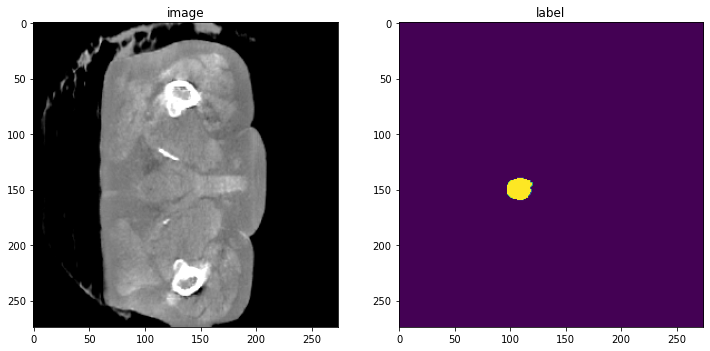

In [9]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 20], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 20])
plt.show()

In [22]:
np.histogram(label,bins=[0,1,2,3,4,5])

(array([6195285,   30037,   68571,   12491,       0]),
 array([0, 1, 2, 3, 4, 5]))

In [10]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
#train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
#val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


In [12]:
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=4,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [96]:
print(model)

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


In [17]:
max_epochs = 600
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=4)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=4)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (64, 64, 64)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                #val_outputs = torch.FloatTensor(val_outputs)
                #val_labels = torch.FloatTensor(val_labels)
                #print(torch.max(val_outputs[0]))
                #print(torch.max(val_labels[0]))
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    data_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/600
1/28, train_loss: 0.0375
2/28, train_loss: 0.0835
3/28, train_loss: 0.1154
4/28, train_loss: 0.1046
5/28, train_loss: 0.0542
6/28, train_loss: 0.1108
7/28, train_loss: 0.0923
8/28, train_loss: 0.0537
9/28, train_loss: 0.2117
10/28, train_loss: 0.1005
11/28, train_loss: 0.0479
12/28, train_loss: 0.0559
13/28, train_loss: 0.0602
14/28, train_loss: 0.0656
15/28, train_loss: 0.1353
16/28, train_loss: 0.1681
17/28, train_loss: 0.1559
18/28, train_loss: 0.0742
19/28, train_loss: 0.0787
20/28, train_loss: 0.0722
21/28, train_loss: 0.0274
22/28, train_loss: 0.0634
23/28, train_loss: 0.0963
24/28, train_loss: 0.0874
25/28, train_loss: 0.0581
26/28, train_loss: 0.0814
27/28, train_loss: 0.0411
28/28, train_loss: 0.0462
epoch 1 average loss: 0.0850
saved new best metric model
current epoch: 1 current mean dice: 0.7827
best mean dice: 0.7827 at epoch: 1
----------
epoch 2/600
1/28, train_loss: 0.0398
2/28, train_loss: 0.0636
3/28, train_loss: 0.0123
4/28, train_loss: 0.0928


18/28, train_loss: 0.0543
19/28, train_loss: 0.0351
20/28, train_loss: 0.0440
21/28, train_loss: 0.1201
22/28, train_loss: 0.1004
23/28, train_loss: 0.0291
24/28, train_loss: 0.0729
25/28, train_loss: 0.0937
26/28, train_loss: 0.0716
27/28, train_loss: 0.0594
28/28, train_loss: 0.1972
epoch 10 average loss: 0.0806
current epoch: 10 current mean dice: 0.7494
best mean dice: 0.7957 at epoch: 5
----------
epoch 11/600
1/28, train_loss: 0.1586
2/28, train_loss: 0.0932
3/28, train_loss: 0.0765
4/28, train_loss: 0.0852
5/28, train_loss: 0.1099
6/28, train_loss: 0.1040
7/28, train_loss: 0.1119
8/28, train_loss: 0.1522
9/28, train_loss: 0.0891
10/28, train_loss: 0.1791
11/28, train_loss: 0.1074
12/28, train_loss: 0.0382
13/28, train_loss: 0.0369
14/28, train_loss: 0.0510
15/28, train_loss: 0.0748
16/28, train_loss: 0.0594
17/28, train_loss: 0.0861
18/28, train_loss: 0.0452
19/28, train_loss: 0.0645
20/28, train_loss: 0.0952
21/28, train_loss: 0.0944
22/28, train_loss: 0.0564
23/28, train_loss:

6/28, train_loss: 0.1793
7/28, train_loss: 0.0488
8/28, train_loss: 0.0506
9/28, train_loss: 0.1403
10/28, train_loss: 0.0581
11/28, train_loss: 0.0814
12/28, train_loss: 0.1397
13/28, train_loss: 0.1050
14/28, train_loss: 0.0738
15/28, train_loss: 0.1244
16/28, train_loss: 0.0508
17/28, train_loss: 0.0825
18/28, train_loss: 0.0816
19/28, train_loss: 0.0167
20/28, train_loss: 0.1388
21/28, train_loss: 0.0727
22/28, train_loss: 0.1897
23/28, train_loss: 0.2041
24/28, train_loss: 0.1622
25/28, train_loss: 0.2194
26/28, train_loss: 0.0865
27/28, train_loss: 0.0503
28/28, train_loss: 0.0867
epoch 20 average loss: 0.1037
current epoch: 20 current mean dice: 0.7257
best mean dice: 0.7957 at epoch: 5
----------
epoch 21/600
1/28, train_loss: 0.1398
2/28, train_loss: 0.0390
3/28, train_loss: 0.0771
4/28, train_loss: 0.1120
5/28, train_loss: 0.1606
6/28, train_loss: 0.0969
7/28, train_loss: 0.1287
8/28, train_loss: 0.1749
9/28, train_loss: 0.1008
10/28, train_loss: 0.0688
11/28, train_loss: 0.0

27/28, train_loss: 0.1071
28/28, train_loss: 0.0891
epoch 29 average loss: 0.0769
current epoch: 29 current mean dice: 0.7626
best mean dice: 0.7957 at epoch: 5
----------
epoch 30/600
1/28, train_loss: 0.1960
2/28, train_loss: 0.0558
3/28, train_loss: 0.0615
4/28, train_loss: 0.0759
5/28, train_loss: 0.1506
6/28, train_loss: 0.1013
7/28, train_loss: 0.1883
8/28, train_loss: 0.0985
9/28, train_loss: 0.1115
10/28, train_loss: 0.0979
11/28, train_loss: 0.0235
12/28, train_loss: 0.1236
13/28, train_loss: 0.0195
14/28, train_loss: 0.0291
15/28, train_loss: 0.0447
16/28, train_loss: 0.1041
17/28, train_loss: 0.1427
18/28, train_loss: 0.1075
19/28, train_loss: 0.0384
20/28, train_loss: 0.0620
21/28, train_loss: 0.1554
22/28, train_loss: 0.1173
23/28, train_loss: 0.0573
24/28, train_loss: 0.1438
25/28, train_loss: 0.0404
26/28, train_loss: 0.0824
27/28, train_loss: 0.1902
28/28, train_loss: 0.0743
epoch 30 average loss: 0.0962
current epoch: 30 current mean dice: 0.7790
best mean dice: 0.7957

15/28, train_loss: 0.1487
16/28, train_loss: 0.0451
17/28, train_loss: 0.0772
18/28, train_loss: 0.1926
19/28, train_loss: 0.1208
20/28, train_loss: 0.1768
21/28, train_loss: 0.0688
22/28, train_loss: 0.1034
23/28, train_loss: 0.1234
24/28, train_loss: 0.0918
25/28, train_loss: 0.0848
26/28, train_loss: 0.0578
27/28, train_loss: 0.1420
28/28, train_loss: 0.1244
epoch 39 average loss: 0.1015
current epoch: 39 current mean dice: 0.7334
best mean dice: 0.7957 at epoch: 5
----------
epoch 40/600
1/28, train_loss: 0.1300
2/28, train_loss: 0.1354
3/28, train_loss: 0.1215
4/28, train_loss: 0.1183
5/28, train_loss: 0.1023
6/28, train_loss: 0.0598
7/28, train_loss: 0.0414
8/28, train_loss: 0.0662
9/28, train_loss: 0.1286
10/28, train_loss: 0.0585
11/28, train_loss: 0.0403
12/28, train_loss: 0.0581
13/28, train_loss: 0.0933
14/28, train_loss: 0.1236
15/28, train_loss: 0.2165
16/28, train_loss: 0.2066
17/28, train_loss: 0.0878
18/28, train_loss: 0.0613
19/28, train_loss: 0.1030
20/28, train_loss:

3/28, train_loss: 0.0576
4/28, train_loss: 0.0818
5/28, train_loss: 0.1050
6/28, train_loss: 0.0816
7/28, train_loss: 0.1273
8/28, train_loss: 0.1695
9/28, train_loss: 0.1363
10/28, train_loss: 0.1039
11/28, train_loss: 0.0242
12/28, train_loss: 0.1449
13/28, train_loss: 0.0519
14/28, train_loss: 0.2051
15/28, train_loss: 0.0755
16/28, train_loss: 0.0521
17/28, train_loss: 0.1100
18/28, train_loss: 0.0923
19/28, train_loss: 0.1079
20/28, train_loss: 0.0597
21/28, train_loss: 0.0470
22/28, train_loss: 0.0561
23/28, train_loss: 0.0111
24/28, train_loss: 0.0744
25/28, train_loss: 0.0755
26/28, train_loss: 0.1361
27/28, train_loss: 0.0524
28/28, train_loss: 0.0172
epoch 49 average loss: 0.0886
current epoch: 49 current mean dice: 0.7353
best mean dice: 0.7957 at epoch: 5
----------
epoch 50/600
1/28, train_loss: 0.1107
2/28, train_loss: 0.0705
3/28, train_loss: 0.0635
4/28, train_loss: 0.0549
5/28, train_loss: 0.0776
6/28, train_loss: 0.0944
7/28, train_loss: 0.1043
8/28, train_loss: 0.117

24/28, train_loss: 0.0218
25/28, train_loss: 0.1189
26/28, train_loss: 0.1068
27/28, train_loss: 0.0749
28/28, train_loss: 0.1363
epoch 58 average loss: 0.0960
current epoch: 58 current mean dice: 0.7467
best mean dice: 0.7957 at epoch: 5
----------
epoch 59/600
1/28, train_loss: 0.1934
2/28, train_loss: 0.0688
3/28, train_loss: 0.1505
4/28, train_loss: 0.0728
5/28, train_loss: 0.1248
6/28, train_loss: 0.0470
7/28, train_loss: 0.0195
8/28, train_loss: 0.0679
9/28, train_loss: 0.0474
10/28, train_loss: 0.0829
11/28, train_loss: 0.1456
12/28, train_loss: 0.0487
13/28, train_loss: 0.1372
14/28, train_loss: 0.0364
15/28, train_loss: 0.0744
16/28, train_loss: 0.0966
17/28, train_loss: 0.1561
18/28, train_loss: 0.0850
19/28, train_loss: 0.0768
20/28, train_loss: 0.0673
21/28, train_loss: 0.0268
22/28, train_loss: 0.1282
23/28, train_loss: 0.1469
24/28, train_loss: 0.0585
25/28, train_loss: 0.1611
26/28, train_loss: 0.0352
27/28, train_loss: 0.0764
28/28, train_loss: 0.0705
epoch 59 average l

12/28, train_loss: 0.0911
13/28, train_loss: 0.0978
14/28, train_loss: 0.1110
15/28, train_loss: 0.1106
16/28, train_loss: 0.1425
17/28, train_loss: 0.1497
18/28, train_loss: 0.0337
19/28, train_loss: 0.0870
20/28, train_loss: 0.0759
21/28, train_loss: 0.0610
22/28, train_loss: 0.0812
23/28, train_loss: 0.1390
24/28, train_loss: 0.1436
25/28, train_loss: 0.0433
26/28, train_loss: 0.1173
27/28, train_loss: 0.1291
28/28, train_loss: 0.1107
epoch 68 average loss: 0.0964
current epoch: 68 current mean dice: 0.7757
best mean dice: 0.7957 at epoch: 5
----------
epoch 69/600
1/28, train_loss: 0.0680
2/28, train_loss: 0.0564
3/28, train_loss: 0.1726
4/28, train_loss: 0.0871
5/28, train_loss: 0.0624
6/28, train_loss: 0.1569
7/28, train_loss: 0.0395
8/28, train_loss: 0.0680
9/28, train_loss: 0.1129
10/28, train_loss: 0.1014
11/28, train_loss: 0.1696
12/28, train_loss: 0.0339
13/28, train_loss: 0.0471
14/28, train_loss: 0.0962
15/28, train_loss: 0.0499
16/28, train_loss: 0.0335
17/28, train_loss:

1/28, train_loss: 0.0878
2/28, train_loss: 0.0745
3/28, train_loss: 0.1321
4/28, train_loss: 0.0356
5/28, train_loss: 0.0858
6/28, train_loss: 0.1014
7/28, train_loss: 0.1268
8/28, train_loss: 0.1160
9/28, train_loss: 0.0484
10/28, train_loss: 0.1362
11/28, train_loss: 0.1087
12/28, train_loss: 0.0552
13/28, train_loss: 0.1232
14/28, train_loss: 0.1075
15/28, train_loss: 0.1027
16/28, train_loss: 0.0819
17/28, train_loss: 0.0865
18/28, train_loss: 0.1465
19/28, train_loss: 0.0814
20/28, train_loss: 0.0284
21/28, train_loss: 0.1519
22/28, train_loss: 0.0438
23/28, train_loss: 0.0545
24/28, train_loss: 0.0928
25/28, train_loss: 0.0136
26/28, train_loss: 0.0628
27/28, train_loss: 0.0531
28/28, train_loss: 0.0717
epoch 78 average loss: 0.0861
current epoch: 78 current mean dice: 0.7494
best mean dice: 0.7957 at epoch: 5
----------
epoch 79/600
1/28, train_loss: 0.0452
2/28, train_loss: 0.0471
3/28, train_loss: 0.0399
4/28, train_loss: 0.0336
5/28, train_loss: 0.0625
6/28, train_loss: 0.033

22/28, train_loss: 0.0759
23/28, train_loss: 0.1196
24/28, train_loss: 0.1268
25/28, train_loss: 0.0742
26/28, train_loss: 0.1010
27/28, train_loss: 0.1113
28/28, train_loss: 0.0517
epoch 87 average loss: 0.0806
current epoch: 87 current mean dice: 0.7864
best mean dice: 0.7957 at epoch: 5
----------
epoch 88/600
1/28, train_loss: 0.0465
2/28, train_loss: 0.0874
3/28, train_loss: 0.0870
4/28, train_loss: 0.0705
5/28, train_loss: 0.0371
6/28, train_loss: 0.0711
7/28, train_loss: 0.0989
8/28, train_loss: 0.0586
9/28, train_loss: 0.1478
10/28, train_loss: 0.0988
11/28, train_loss: 0.1056
12/28, train_loss: 0.0604
13/28, train_loss: 0.0462
14/28, train_loss: 0.0702
15/28, train_loss: 0.1298
16/28, train_loss: 0.0453
17/28, train_loss: 0.0144
18/28, train_loss: 0.0565
19/28, train_loss: 0.0847
20/28, train_loss: 0.0658
21/28, train_loss: 0.1238
22/28, train_loss: 0.0970
23/28, train_loss: 0.1248
24/28, train_loss: 0.0516
25/28, train_loss: 0.0499
26/28, train_loss: 0.1026
27/28, train_loss:

8/28, train_loss: 0.0872
9/28, train_loss: 0.0813
10/28, train_loss: 0.0939
11/28, train_loss: 0.1145
12/28, train_loss: 0.0624
13/28, train_loss: 0.0749
14/28, train_loss: 0.0678
15/28, train_loss: 0.0574
16/28, train_loss: 0.1634
17/28, train_loss: 0.1030
18/28, train_loss: 0.1488
19/28, train_loss: 0.0150
20/28, train_loss: 0.1263
21/28, train_loss: 0.1567
22/28, train_loss: 0.0680
23/28, train_loss: 0.0952
24/28, train_loss: 0.0459
25/28, train_loss: 0.0741
26/28, train_loss: 0.0635
27/28, train_loss: 0.0756
28/28, train_loss: 0.0996
epoch 97 average loss: 0.0903
current epoch: 97 current mean dice: 0.7873
best mean dice: 0.8002 at epoch: 88
----------
epoch 98/600
1/28, train_loss: 0.0480
2/28, train_loss: 0.1173
3/28, train_loss: 0.0572
4/28, train_loss: 0.0390
5/28, train_loss: 0.1350
6/28, train_loss: 0.0411
7/28, train_loss: 0.1182
8/28, train_loss: 0.0402
9/28, train_loss: 0.1207
10/28, train_loss: 0.0730
11/28, train_loss: 0.0473
12/28, train_loss: 0.0986
13/28, train_loss: 

28/28, train_loss: 0.0862
epoch 106 average loss: 0.0874
current epoch: 106 current mean dice: 0.7542
best mean dice: 0.8002 at epoch: 88
----------
epoch 107/600
1/28, train_loss: 0.1076
2/28, train_loss: 0.0572
3/28, train_loss: 0.0683
4/28, train_loss: 0.0838
5/28, train_loss: 0.0512
6/28, train_loss: 0.1498
7/28, train_loss: 0.1598
8/28, train_loss: 0.0538
9/28, train_loss: 0.1111
10/28, train_loss: 0.0920
11/28, train_loss: 0.0907
12/28, train_loss: 0.0626
13/28, train_loss: 0.0576
14/28, train_loss: 0.0943
15/28, train_loss: 0.0894
16/28, train_loss: 0.0712
17/28, train_loss: 0.1544
18/28, train_loss: 0.1073
19/28, train_loss: 0.0500
20/28, train_loss: 0.0645
21/28, train_loss: 0.0574
22/28, train_loss: 0.0906
23/28, train_loss: 0.0956
24/28, train_loss: 0.1284
25/28, train_loss: 0.1674
26/28, train_loss: 0.0741
27/28, train_loss: 0.0894
28/28, train_loss: 0.1892
epoch 107 average loss: 0.0953
current epoch: 107 current mean dice: 0.7508
best mean dice: 0.8002 at epoch: 88
------

14/28, train_loss: 0.1180
15/28, train_loss: 0.0351
16/28, train_loss: 0.0747
17/28, train_loss: 0.0878
18/28, train_loss: 0.0704
19/28, train_loss: 0.0805
20/28, train_loss: 0.0637
21/28, train_loss: 0.1014
22/28, train_loss: 0.0365
23/28, train_loss: 0.0898
24/28, train_loss: 0.0899
25/28, train_loss: 0.0614
26/28, train_loss: 0.1309
27/28, train_loss: 0.0668
28/28, train_loss: 0.1823
epoch 116 average loss: 0.0957
current epoch: 116 current mean dice: 0.7895
best mean dice: 0.8002 at epoch: 88
----------
epoch 117/600
1/28, train_loss: 0.1308
2/28, train_loss: 0.0825
3/28, train_loss: 0.1226
4/28, train_loss: 0.1258
5/28, train_loss: 0.0731
6/28, train_loss: 0.0692
7/28, train_loss: 0.0824
8/28, train_loss: 0.0546
9/28, train_loss: 0.0588
10/28, train_loss: 0.0830
11/28, train_loss: 0.0434
12/28, train_loss: 0.0903
13/28, train_loss: 0.1150
14/28, train_loss: 0.1150
15/28, train_loss: 0.1037
16/28, train_loss: 0.1216
17/28, train_loss: 0.1399
18/28, train_loss: 0.0548
19/28, train_l

1/28, train_loss: 0.0507
2/28, train_loss: 0.1249
3/28, train_loss: 0.0740
4/28, train_loss: 0.0232
5/28, train_loss: 0.1037
6/28, train_loss: 0.2071
7/28, train_loss: 0.0929
8/28, train_loss: 0.0567
9/28, train_loss: 0.0693
10/28, train_loss: 0.0904
11/28, train_loss: 0.0730
12/28, train_loss: 0.0505
13/28, train_loss: 0.1098
14/28, train_loss: 0.0331
15/28, train_loss: 0.0692
16/28, train_loss: 0.2117
17/28, train_loss: 0.1091
18/28, train_loss: 0.0729
19/28, train_loss: 0.1306
20/28, train_loss: 0.0840
21/28, train_loss: 0.0630
22/28, train_loss: 0.0656
23/28, train_loss: 0.0909
24/28, train_loss: 0.1121
25/28, train_loss: 0.0860
26/28, train_loss: 0.0824
27/28, train_loss: 0.0889
28/28, train_loss: 0.1032
epoch 126 average loss: 0.0903
current epoch: 126 current mean dice: 0.7951
best mean dice: 0.8002 at epoch: 88
----------
epoch 127/600
1/28, train_loss: 0.1183
2/28, train_loss: 0.0929
3/28, train_loss: 0.0927
4/28, train_loss: 0.0179
5/28, train_loss: 0.0898
6/28, train_loss: 0

17/28, train_loss: 0.0669
18/28, train_loss: 0.0899
19/28, train_loss: 0.0470
20/28, train_loss: 0.1008
21/28, train_loss: 0.0780
22/28, train_loss: 0.1008
23/28, train_loss: 0.0370
24/28, train_loss: 0.1020
25/28, train_loss: 0.1316
26/28, train_loss: 0.0960
27/28, train_loss: 0.0744
28/28, train_loss: 0.0832
epoch 135 average loss: 0.0882
current epoch: 135 current mean dice: 0.7653
best mean dice: 0.8094 at epoch: 134
----------
epoch 136/600
1/28, train_loss: 0.1210
2/28, train_loss: 0.0923
3/28, train_loss: 0.0756
4/28, train_loss: 0.1021
5/28, train_loss: 0.1756
6/28, train_loss: 0.1175
7/28, train_loss: 0.1463
8/28, train_loss: 0.0922
9/28, train_loss: 0.1343
10/28, train_loss: 0.1859
11/28, train_loss: 0.0970
12/28, train_loss: 0.1254
13/28, train_loss: 0.1751
14/28, train_loss: 0.1787
15/28, train_loss: 0.1161
16/28, train_loss: 0.0631
17/28, train_loss: 0.1004
18/28, train_loss: 0.1097
19/28, train_loss: 0.0463
20/28, train_loss: 0.0884
21/28, train_loss: 0.1160
22/28, train_

3/28, train_loss: 0.0943
4/28, train_loss: 0.0458
5/28, train_loss: 0.0621
6/28, train_loss: 0.0854
7/28, train_loss: 0.0288
8/28, train_loss: 0.0600
9/28, train_loss: 0.0650
10/28, train_loss: 0.1012
11/28, train_loss: 0.0523
12/28, train_loss: 0.1295
13/28, train_loss: 0.0772
14/28, train_loss: 0.0794
15/28, train_loss: 0.0785
16/28, train_loss: 0.0952
17/28, train_loss: 0.0470
18/28, train_loss: 0.0570
19/28, train_loss: 0.0501
20/28, train_loss: 0.0979
21/28, train_loss: 0.1259
22/28, train_loss: 0.1252
23/28, train_loss: 0.0794
24/28, train_loss: 0.0490
25/28, train_loss: 0.0656
26/28, train_loss: 0.1380
27/28, train_loss: 0.0884
28/28, train_loss: 0.0731
epoch 145 average loss: 0.0788
current epoch: 145 current mean dice: 0.7868
best mean dice: 0.8094 at epoch: 134
----------
epoch 146/600
1/28, train_loss: 0.0742
2/28, train_loss: 0.1306
3/28, train_loss: 0.0535
4/28, train_loss: 0.0170
5/28, train_loss: 0.0741
6/28, train_loss: 0.1109
7/28, train_loss: 0.0819
8/28, train_loss: 

22/28, train_loss: 0.0434
23/28, train_loss: 0.0485
24/28, train_loss: 0.0595
25/28, train_loss: 0.0640
26/28, train_loss: 0.0576
27/28, train_loss: 0.0767
28/28, train_loss: 0.0612
epoch 154 average loss: 0.0864
current epoch: 154 current mean dice: 0.7596
best mean dice: 0.8094 at epoch: 134
----------
epoch 155/600
1/28, train_loss: 0.0586
2/28, train_loss: 0.2009
3/28, train_loss: 0.0912
4/28, train_loss: 0.1479
5/28, train_loss: 0.1999
6/28, train_loss: 0.0672
7/28, train_loss: 0.1448
8/28, train_loss: 0.1670
9/28, train_loss: 0.1482
10/28, train_loss: 0.0768
11/28, train_loss: 0.0381
12/28, train_loss: 0.0676
13/28, train_loss: 0.0504
14/28, train_loss: 0.0963
15/28, train_loss: 0.0160
16/28, train_loss: 0.1879
17/28, train_loss: 0.1159
18/28, train_loss: 0.1343
19/28, train_loss: 0.0592
20/28, train_loss: 0.1205
21/28, train_loss: 0.1045
22/28, train_loss: 0.0289
23/28, train_loss: 0.1122
24/28, train_loss: 0.0796
25/28, train_loss: 0.1360
26/28, train_loss: 0.1941
27/28, train_

8/28, train_loss: 0.1113
9/28, train_loss: 0.1489
10/28, train_loss: 0.1105
11/28, train_loss: 0.1319
12/28, train_loss: 0.1433
13/28, train_loss: 0.1472
14/28, train_loss: 0.0606
15/28, train_loss: 0.1052
16/28, train_loss: 0.1448
17/28, train_loss: 0.0593
18/28, train_loss: 0.0737
19/28, train_loss: 0.1343
20/28, train_loss: 0.0640
21/28, train_loss: 0.0544
22/28, train_loss: 0.1250
23/28, train_loss: 0.0560
24/28, train_loss: 0.1451
25/28, train_loss: 0.0427
26/28, train_loss: 0.0848
27/28, train_loss: 0.1051
28/28, train_loss: 0.0877
epoch 164 average loss: 0.1061
current epoch: 164 current mean dice: 0.7533
best mean dice: 0.8094 at epoch: 134
----------
epoch 165/600
1/28, train_loss: 0.0955
2/28, train_loss: 0.0833
3/28, train_loss: 0.1235
4/28, train_loss: 0.1882
5/28, train_loss: 0.1254
6/28, train_loss: 0.1324
7/28, train_loss: 0.0890
8/28, train_loss: 0.0907
9/28, train_loss: 0.0654
10/28, train_loss: 0.0798
11/28, train_loss: 0.2501
12/28, train_loss: 0.1623
13/28, train_lo

27/28, train_loss: 0.0501
28/28, train_loss: 0.0791
epoch 173 average loss: 0.0776
current epoch: 173 current mean dice: 0.7687
best mean dice: 0.8094 at epoch: 134
----------
epoch 174/600
1/28, train_loss: 0.1218
2/28, train_loss: 0.1406
3/28, train_loss: 0.0406
4/28, train_loss: 0.0381
5/28, train_loss: 0.1720
6/28, train_loss: 0.1573
7/28, train_loss: 0.1434
8/28, train_loss: 0.0742
9/28, train_loss: 0.0692
10/28, train_loss: 0.0671
11/28, train_loss: 0.0967
12/28, train_loss: 0.0542
13/28, train_loss: 0.0724
14/28, train_loss: 0.0968
15/28, train_loss: 0.1187
16/28, train_loss: 0.0330
17/28, train_loss: 0.0199
18/28, train_loss: 0.0596
19/28, train_loss: 0.0894
20/28, train_loss: 0.1074
21/28, train_loss: 0.0842
22/28, train_loss: 0.0737
23/28, train_loss: 0.0217
24/28, train_loss: 0.0686
25/28, train_loss: 0.0658
26/28, train_loss: 0.0768
27/28, train_loss: 0.1330
28/28, train_loss: 0.0918
epoch 174 average loss: 0.0853
current epoch: 174 current mean dice: 0.7760
best mean dice:

13/28, train_loss: 0.0185
14/28, train_loss: 0.2171
15/28, train_loss: 0.1563
16/28, train_loss: 0.0741
17/28, train_loss: 0.0884
18/28, train_loss: 0.0781
19/28, train_loss: 0.1034
20/28, train_loss: 0.0899
21/28, train_loss: 0.0745
22/28, train_loss: 0.1443
23/28, train_loss: 0.1170
24/28, train_loss: 0.1092
25/28, train_loss: 0.1294
26/28, train_loss: 0.0524
27/28, train_loss: 0.0587
28/28, train_loss: 0.0700
epoch 183 average loss: 0.0923
current epoch: 183 current mean dice: 0.7606
best mean dice: 0.8094 at epoch: 134
----------
epoch 184/600
1/28, train_loss: 0.1022
2/28, train_loss: 0.0538
3/28, train_loss: 0.0688
4/28, train_loss: 0.0999
5/28, train_loss: 0.0418
6/28, train_loss: 0.1655
7/28, train_loss: 0.1436
8/28, train_loss: 0.0402
9/28, train_loss: 0.1201
10/28, train_loss: 0.0803
11/28, train_loss: 0.0568
12/28, train_loss: 0.1201
13/28, train_loss: 0.0796
14/28, train_loss: 0.0831
15/28, train_loss: 0.0350
16/28, train_loss: 0.0818
17/28, train_loss: 0.0597
18/28, train_

1/28, train_loss: 0.2076
2/28, train_loss: 0.0784
3/28, train_loss: 0.1413
4/28, train_loss: 0.0586
5/28, train_loss: 0.0856
6/28, train_loss: 0.0524
7/28, train_loss: 0.0690
8/28, train_loss: 0.1116
9/28, train_loss: 0.1057
10/28, train_loss: 0.2071
11/28, train_loss: 0.1164
12/28, train_loss: 0.2560
13/28, train_loss: 0.1039
14/28, train_loss: 0.1022
15/28, train_loss: 0.1091
16/28, train_loss: 0.1640
17/28, train_loss: 0.0177
18/28, train_loss: 0.0445
19/28, train_loss: 0.0586
20/28, train_loss: 0.1016
21/28, train_loss: 0.0981
22/28, train_loss: 0.1806
23/28, train_loss: 0.2145
24/28, train_loss: 0.1094
25/28, train_loss: 0.1122
26/28, train_loss: 0.0653
27/28, train_loss: 0.0839
28/28, train_loss: 0.1453
epoch 193 average loss: 0.1143
current epoch: 193 current mean dice: 0.7416
best mean dice: 0.8094 at epoch: 134
----------
epoch 194/600
1/28, train_loss: 0.0845
2/28, train_loss: 0.0489
3/28, train_loss: 0.0752
4/28, train_loss: 0.0406
5/28, train_loss: 0.1124
6/28, train_loss: 

20/28, train_loss: 0.0375
21/28, train_loss: 0.0280
22/28, train_loss: 0.1083
23/28, train_loss: 0.0536
24/28, train_loss: 0.1111
25/28, train_loss: 0.0655
26/28, train_loss: 0.1419
27/28, train_loss: 0.0396
28/28, train_loss: 0.0827
epoch 202 average loss: 0.0888
current epoch: 202 current mean dice: 0.7466
best mean dice: 0.8094 at epoch: 134
----------
epoch 203/600
1/28, train_loss: 0.0782
2/28, train_loss: 0.1710
3/28, train_loss: 0.0881
4/28, train_loss: 0.0596
5/28, train_loss: 0.0516
6/28, train_loss: 0.1014
7/28, train_loss: 0.0806
8/28, train_loss: 0.0296
9/28, train_loss: 0.0902
10/28, train_loss: 0.1375
11/28, train_loss: 0.0424
12/28, train_loss: 0.1133
13/28, train_loss: 0.0637
14/28, train_loss: 0.1144
15/28, train_loss: 0.1562
16/28, train_loss: 0.0488
17/28, train_loss: 0.0779
18/28, train_loss: 0.1004
19/28, train_loss: 0.1059
20/28, train_loss: 0.1062
21/28, train_loss: 0.0476
22/28, train_loss: 0.1762
23/28, train_loss: 0.1854
24/28, train_loss: 0.0703
25/28, train_

6/28, train_loss: 0.0859
7/28, train_loss: 0.0460
8/28, train_loss: 0.0697
9/28, train_loss: 0.0687
10/28, train_loss: 0.0605
11/28, train_loss: 0.0923
12/28, train_loss: 0.0449
13/28, train_loss: 0.0759
14/28, train_loss: 0.0884
15/28, train_loss: 0.1380
16/28, train_loss: 0.0584
17/28, train_loss: 0.1447
18/28, train_loss: 0.0742
19/28, train_loss: 0.0890
20/28, train_loss: 0.1209
21/28, train_loss: 0.0663
22/28, train_loss: 0.0593
23/28, train_loss: 0.1631
24/28, train_loss: 0.0410
25/28, train_loss: 0.0384
26/28, train_loss: 0.0874
27/28, train_loss: 0.0540
28/28, train_loss: 0.0448
epoch 212 average loss: 0.0841
current epoch: 212 current mean dice: 0.7672
best mean dice: 0.8094 at epoch: 134
----------
epoch 213/600
1/28, train_loss: 0.1085
2/28, train_loss: 0.1030
3/28, train_loss: 0.0780
4/28, train_loss: 0.1207
5/28, train_loss: 0.0514
6/28, train_loss: 0.0925
7/28, train_loss: 0.1052
8/28, train_loss: 0.0725
9/28, train_loss: 0.1028
10/28, train_loss: 0.1475
11/28, train_loss

25/28, train_loss: 0.0591
26/28, train_loss: 0.0292
27/28, train_loss: 0.1443
28/28, train_loss: 0.0957
epoch 221 average loss: 0.0877
current epoch: 221 current mean dice: 0.7692
best mean dice: 0.8094 at epoch: 134
----------
epoch 222/600
1/28, train_loss: 0.1715
2/28, train_loss: 0.0805
3/28, train_loss: 0.0099
4/28, train_loss: 0.0499
5/28, train_loss: 0.1032
6/28, train_loss: 0.0438
7/28, train_loss: 0.1274
8/28, train_loss: 0.0618
9/28, train_loss: 0.0449
10/28, train_loss: 0.0363
11/28, train_loss: 0.0391
12/28, train_loss: 0.0540
13/28, train_loss: 0.1318
14/28, train_loss: 0.0460
15/28, train_loss: 0.1363
16/28, train_loss: 0.0506
17/28, train_loss: 0.0847
18/28, train_loss: 0.0909
19/28, train_loss: 0.1325
20/28, train_loss: 0.0872
21/28, train_loss: 0.1156
22/28, train_loss: 0.0322
23/28, train_loss: 0.1476
24/28, train_loss: 0.0614
25/28, train_loss: 0.0393
26/28, train_loss: 0.0571
27/28, train_loss: 0.1297
28/28, train_loss: 0.0471
epoch 222 average loss: 0.0790
current 

11/28, train_loss: 0.1373
12/28, train_loss: 0.0668
13/28, train_loss: 0.0813
14/28, train_loss: 0.1509
15/28, train_loss: 0.0630
16/28, train_loss: 0.0284
17/28, train_loss: 0.1551
18/28, train_loss: 0.0619
19/28, train_loss: 0.0512
20/28, train_loss: 0.0672
21/28, train_loss: 0.0508
22/28, train_loss: 0.0404
23/28, train_loss: 0.0972
24/28, train_loss: 0.1185
25/28, train_loss: 0.0872
26/28, train_loss: 0.0742
27/28, train_loss: 0.0714
28/28, train_loss: 0.0250
epoch 231 average loss: 0.0809
current epoch: 231 current mean dice: 0.7709
best mean dice: 0.8094 at epoch: 134
----------
epoch 232/600
1/28, train_loss: 0.0428
2/28, train_loss: 0.0612
3/28, train_loss: 0.0170
4/28, train_loss: 0.0569
5/28, train_loss: 0.0916
6/28, train_loss: 0.0716
7/28, train_loss: 0.1221
8/28, train_loss: 0.0800
9/28, train_loss: 0.1560
10/28, train_loss: 0.0448
11/28, train_loss: 0.1074
12/28, train_loss: 0.0901
13/28, train_loss: 0.0660
14/28, train_loss: 0.1050
15/28, train_loss: 0.1134
16/28, train_

current epoch: 240 current mean dice: 0.7862
best mean dice: 0.8094 at epoch: 134
----------
epoch 241/600
1/28, train_loss: 0.0303
2/28, train_loss: 0.0844
3/28, train_loss: 0.0706
4/28, train_loss: 0.0296
5/28, train_loss: 0.0462
6/28, train_loss: 0.1130
7/28, train_loss: 0.1159
8/28, train_loss: 0.0212
9/28, train_loss: 0.1574
10/28, train_loss: 0.0688
11/28, train_loss: 0.0195
12/28, train_loss: 0.1624
13/28, train_loss: 0.0643
14/28, train_loss: 0.0513
15/28, train_loss: 0.0457
16/28, train_loss: 0.0526
17/28, train_loss: 0.0666
18/28, train_loss: 0.0788
19/28, train_loss: 0.0735
20/28, train_loss: 0.1120
21/28, train_loss: 0.0562
22/28, train_loss: 0.0741
23/28, train_loss: 0.0695
24/28, train_loss: 0.0525
25/28, train_loss: 0.0408
26/28, train_loss: 0.0729
27/28, train_loss: 0.1155
28/28, train_loss: 0.0342
epoch 241 average loss: 0.0707
current epoch: 241 current mean dice: 0.7815
best mean dice: 0.8094 at epoch: 134
----------
epoch 242/600
1/28, train_loss: 0.0236
2/28, train

16/28, train_loss: 0.1891
17/28, train_loss: 0.0412
18/28, train_loss: 0.0398
19/28, train_loss: 0.2335
20/28, train_loss: 0.0439
21/28, train_loss: 0.1449
22/28, train_loss: 0.0507
23/28, train_loss: 0.0661
24/28, train_loss: 0.1385
25/28, train_loss: 0.0884
26/28, train_loss: 0.1503
27/28, train_loss: 0.1589
28/28, train_loss: 0.0947
epoch 250 average loss: 0.1217
current epoch: 250 current mean dice: 0.6830
best mean dice: 0.8094 at epoch: 134
----------
epoch 251/600
1/28, train_loss: 0.1043
2/28, train_loss: 0.0955
3/28, train_loss: 0.1067
4/28, train_loss: 0.1856
5/28, train_loss: 0.0331
6/28, train_loss: 0.0812
7/28, train_loss: 0.1410
8/28, train_loss: 0.1515
9/28, train_loss: 0.0390
10/28, train_loss: 0.1308
11/28, train_loss: 0.1190
12/28, train_loss: 0.0757
13/28, train_loss: 0.0792
14/28, train_loss: 0.0461
15/28, train_loss: 0.0777
16/28, train_loss: 0.1891
17/28, train_loss: 0.0481
18/28, train_loss: 0.0781
19/28, train_loss: 0.1462
20/28, train_loss: 0.0376
21/28, train_

2/28, train_loss: 0.0720
3/28, train_loss: 0.0870
4/28, train_loss: 0.1118
5/28, train_loss: 0.0296
6/28, train_loss: 0.0272
7/28, train_loss: 0.0788
8/28, train_loss: 0.1418
9/28, train_loss: 0.1360
10/28, train_loss: 0.1556
11/28, train_loss: 0.1665
12/28, train_loss: 0.0578
13/28, train_loss: 0.0690
14/28, train_loss: 0.0310
15/28, train_loss: 0.0778
16/28, train_loss: 0.0646
17/28, train_loss: 0.0265
18/28, train_loss: 0.0348
19/28, train_loss: 0.1125
20/28, train_loss: 0.0460
21/28, train_loss: 0.0673
22/28, train_loss: 0.0852
23/28, train_loss: 0.1472
24/28, train_loss: 0.0410
25/28, train_loss: 0.0471
26/28, train_loss: 0.0637
27/28, train_loss: 0.0814
28/28, train_loss: 0.1143
epoch 260 average loss: 0.0806
current epoch: 260 current mean dice: 0.7726
best mean dice: 0.8094 at epoch: 134
----------
epoch 261/600
1/28, train_loss: 0.1010
2/28, train_loss: 0.1429
3/28, train_loss: 0.0863
4/28, train_loss: 0.0469
5/28, train_loss: 0.0501
6/28, train_loss: 0.0541
7/28, train_loss: 

21/28, train_loss: 0.0708
22/28, train_loss: 0.0630
23/28, train_loss: 0.0788
24/28, train_loss: 0.0990
25/28, train_loss: 0.1195
26/28, train_loss: 0.0945
27/28, train_loss: 0.1378
28/28, train_loss: 0.0858
epoch 269 average loss: 0.0877
current epoch: 269 current mean dice: 0.7568
best mean dice: 0.8094 at epoch: 134
----------
epoch 270/600
1/28, train_loss: 0.1003
2/28, train_loss: 0.0401
3/28, train_loss: 0.0358
4/28, train_loss: 0.1195
5/28, train_loss: 0.0795
6/28, train_loss: 0.0763
7/28, train_loss: 0.0890
8/28, train_loss: 0.1466
9/28, train_loss: 0.0958
10/28, train_loss: 0.0471
11/28, train_loss: 0.0355
12/28, train_loss: 0.0898
13/28, train_loss: 0.0725
14/28, train_loss: 0.1271
15/28, train_loss: 0.0858
16/28, train_loss: 0.1093
17/28, train_loss: 0.1236
18/28, train_loss: 0.1211
19/28, train_loss: 0.0832
20/28, train_loss: 0.0987
21/28, train_loss: 0.0673
22/28, train_loss: 0.1304
23/28, train_loss: 0.0645
24/28, train_loss: 0.1151
25/28, train_loss: 0.0793
26/28, train_

7/28, train_loss: 0.0123
8/28, train_loss: 0.1054
9/28, train_loss: 0.0995
10/28, train_loss: 0.0772
11/28, train_loss: 0.0681
12/28, train_loss: 0.1125
13/28, train_loss: 0.1136
14/28, train_loss: 0.0443
15/28, train_loss: 0.0612
16/28, train_loss: 0.1046
17/28, train_loss: 0.0510
18/28, train_loss: 0.0717
19/28, train_loss: 0.1089
20/28, train_loss: 0.1303
21/28, train_loss: 0.0589
22/28, train_loss: 0.1067
23/28, train_loss: 0.0882
24/28, train_loss: 0.0260
25/28, train_loss: 0.0623
26/28, train_loss: 0.0409
27/28, train_loss: 0.0530
28/28, train_loss: 0.0759
epoch 279 average loss: 0.0743
current epoch: 279 current mean dice: 0.7244
best mean dice: 0.8094 at epoch: 134
----------
epoch 280/600
1/28, train_loss: 0.0579
2/28, train_loss: 0.1731
3/28, train_loss: 0.0595
4/28, train_loss: 0.1068
5/28, train_loss: 0.1533
6/28, train_loss: 0.0869
7/28, train_loss: 0.0719
8/28, train_loss: 0.1924
9/28, train_loss: 0.0842
10/28, train_loss: 0.1233
11/28, train_loss: 0.0228
12/28, train_los

26/28, train_loss: 0.0465
27/28, train_loss: 0.0264
28/28, train_loss: 0.0429
epoch 288 average loss: 0.0903
current epoch: 288 current mean dice: 0.7726
best mean dice: 0.8094 at epoch: 134
----------
epoch 289/600
1/28, train_loss: 0.1552
2/28, train_loss: 0.1156
3/28, train_loss: 0.0656
4/28, train_loss: 0.0973
5/28, train_loss: 0.1092
6/28, train_loss: 0.0486
7/28, train_loss: 0.0930
8/28, train_loss: 0.0925
9/28, train_loss: 0.0304
10/28, train_loss: 0.1188
11/28, train_loss: 0.0544
12/28, train_loss: 0.0573
13/28, train_loss: 0.0810
14/28, train_loss: 0.1142
15/28, train_loss: 0.0828
16/28, train_loss: 0.1330
17/28, train_loss: 0.0654
18/28, train_loss: 0.0615
19/28, train_loss: 0.1415
20/28, train_loss: 0.1627
21/28, train_loss: 0.0473
22/28, train_loss: 0.0761
23/28, train_loss: 0.1651
24/28, train_loss: 0.0578
25/28, train_loss: 0.0779
26/28, train_loss: 0.0745
27/28, train_loss: 0.1561
28/28, train_loss: 0.0556
epoch 289 average loss: 0.0925
current epoch: 289 current mean di

12/28, train_loss: 0.0808
13/28, train_loss: 0.0937
14/28, train_loss: 0.1277
15/28, train_loss: 0.1755
16/28, train_loss: 0.0721
17/28, train_loss: 0.0674
18/28, train_loss: 0.1058
19/28, train_loss: 0.1469
20/28, train_loss: 0.0712
21/28, train_loss: 0.1057
22/28, train_loss: 0.0310
23/28, train_loss: 0.0816
24/28, train_loss: 0.0939
25/28, train_loss: 0.0378
26/28, train_loss: 0.0862
27/28, train_loss: 0.1636
28/28, train_loss: 0.1051
epoch 298 average loss: 0.0964
current epoch: 298 current mean dice: 0.7623
best mean dice: 0.8094 at epoch: 134
----------
epoch 299/600
1/28, train_loss: 0.0985
2/28, train_loss: 0.2036
3/28, train_loss: 0.0404
4/28, train_loss: 0.1557
5/28, train_loss: 0.0619
6/28, train_loss: 0.0860
7/28, train_loss: 0.1500
8/28, train_loss: 0.1235
9/28, train_loss: 0.1248
10/28, train_loss: 0.1456
11/28, train_loss: 0.1044
12/28, train_loss: 0.0823
13/28, train_loss: 0.0703
14/28, train_loss: 0.0742
15/28, train_loss: 0.0768
16/28, train_loss: 0.1216
17/28, train_

1/28, train_loss: 0.0758
2/28, train_loss: 0.0403
3/28, train_loss: 0.0536
4/28, train_loss: 0.0789
5/28, train_loss: 0.0488
6/28, train_loss: 0.0832
7/28, train_loss: 0.0628
8/28, train_loss: 0.0336
9/28, train_loss: 0.0977
10/28, train_loss: 0.0476
11/28, train_loss: 0.0358
12/28, train_loss: 0.0734
13/28, train_loss: 0.1019
14/28, train_loss: 0.0577
15/28, train_loss: 0.0347
16/28, train_loss: 0.1238
17/28, train_loss: 0.0691
18/28, train_loss: 0.0530
19/28, train_loss: 0.1145
20/28, train_loss: 0.1951
21/28, train_loss: 0.0996
22/28, train_loss: 0.1212
23/28, train_loss: 0.1133
24/28, train_loss: 0.0859
25/28, train_loss: 0.0422
26/28, train_loss: 0.1335
27/28, train_loss: 0.0436
28/28, train_loss: 0.0518
epoch 308 average loss: 0.0776
current epoch: 308 current mean dice: 0.7519
best mean dice: 0.8094 at epoch: 134
----------
epoch 309/600
1/28, train_loss: 0.0983
2/28, train_loss: 0.0586
3/28, train_loss: 0.0923
4/28, train_loss: 0.0529
5/28, train_loss: 0.0379
6/28, train_loss: 

20/28, train_loss: 0.0315
21/28, train_loss: 0.0379
22/28, train_loss: 0.1059
23/28, train_loss: 0.1199
24/28, train_loss: 0.0973
25/28, train_loss: 0.0429
26/28, train_loss: 0.0478
27/28, train_loss: 0.1266
28/28, train_loss: 0.1237
epoch 317 average loss: 0.0768
current epoch: 317 current mean dice: 0.7666
best mean dice: 0.8094 at epoch: 134
----------
epoch 318/600
1/28, train_loss: 0.1198
2/28, train_loss: 0.1439
3/28, train_loss: 0.1741
4/28, train_loss: 0.1291
5/28, train_loss: 0.1102
6/28, train_loss: 0.0631
7/28, train_loss: 0.1101
8/28, train_loss: 0.0577
9/28, train_loss: 0.1520
10/28, train_loss: 0.1056
11/28, train_loss: 0.0749
12/28, train_loss: 0.0278
13/28, train_loss: 0.0788
14/28, train_loss: 0.0318
15/28, train_loss: 0.0321
16/28, train_loss: 0.0539
17/28, train_loss: 0.1048
18/28, train_loss: 0.0298
19/28, train_loss: 0.0870
20/28, train_loss: 0.0614
21/28, train_loss: 0.0918
22/28, train_loss: 0.0805
23/28, train_loss: 0.0417
24/28, train_loss: 0.1221
25/28, train_

6/28, train_loss: 0.0613
7/28, train_loss: 0.0933
8/28, train_loss: 0.1017
9/28, train_loss: 0.0494
10/28, train_loss: 0.0737
11/28, train_loss: 0.0342
12/28, train_loss: 0.1225
13/28, train_loss: 0.2802
14/28, train_loss: 0.0733
15/28, train_loss: 0.0616
16/28, train_loss: 0.0247
17/28, train_loss: 0.0940
18/28, train_loss: 0.1014
19/28, train_loss: 0.0695
20/28, train_loss: 0.0280
21/28, train_loss: 0.0753
22/28, train_loss: 0.0601
23/28, train_loss: 0.0572
24/28, train_loss: 0.1123
25/28, train_loss: 0.1378
26/28, train_loss: 0.0301
27/28, train_loss: 0.1973
28/28, train_loss: 0.0353
epoch 327 average loss: 0.0840
current epoch: 327 current mean dice: 0.7495
best mean dice: 0.8094 at epoch: 134
----------
epoch 328/600
1/28, train_loss: 0.1758
2/28, train_loss: 0.1926
3/28, train_loss: 0.1125
4/28, train_loss: 0.0876
5/28, train_loss: 0.0881
6/28, train_loss: 0.0245
7/28, train_loss: 0.0685
8/28, train_loss: 0.0677
9/28, train_loss: 0.1520
10/28, train_loss: 0.0788
11/28, train_loss

25/28, train_loss: 0.0756
26/28, train_loss: 0.1055
27/28, train_loss: 0.0296
28/28, train_loss: 0.1535
epoch 336 average loss: 0.0827
current epoch: 336 current mean dice: 0.7583
best mean dice: 0.8094 at epoch: 134
----------
epoch 337/600
1/28, train_loss: 0.0399
2/28, train_loss: 0.0722
3/28, train_loss: 0.0689
4/28, train_loss: 0.1594
5/28, train_loss: 0.0315
6/28, train_loss: 0.0520
7/28, train_loss: 0.1427
8/28, train_loss: 0.0615
9/28, train_loss: 0.1639
10/28, train_loss: 0.0632
11/28, train_loss: 0.0275
12/28, train_loss: 0.1517
13/28, train_loss: 0.1443
14/28, train_loss: 0.1053
15/28, train_loss: 0.0633
16/28, train_loss: 0.0457
17/28, train_loss: 0.0724
18/28, train_loss: 0.0228
19/28, train_loss: 0.0784
20/28, train_loss: 0.0772
21/28, train_loss: 0.1929
22/28, train_loss: 0.1038
23/28, train_loss: 0.1816
24/28, train_loss: 0.1324
25/28, train_loss: 0.1033
26/28, train_loss: 0.0629
27/28, train_loss: 0.0312
28/28, train_loss: 0.0659
epoch 337 average loss: 0.0899
current 

11/28, train_loss: 0.0659
12/28, train_loss: 0.0496
13/28, train_loss: 0.1405
14/28, train_loss: 0.0471
15/28, train_loss: 0.0749
16/28, train_loss: 0.0740
17/28, train_loss: 0.1147
18/28, train_loss: 0.0868
19/28, train_loss: 0.0590
20/28, train_loss: 0.0815
21/28, train_loss: 0.0650
22/28, train_loss: 0.0906
23/28, train_loss: 0.0551
24/28, train_loss: 0.1479
25/28, train_loss: 0.0379
26/28, train_loss: 0.0806
27/28, train_loss: 0.0296
28/28, train_loss: 0.0309
epoch 346 average loss: 0.0828
current epoch: 346 current mean dice: 0.7723
best mean dice: 0.8094 at epoch: 134
----------
epoch 347/600
1/28, train_loss: 0.0779
2/28, train_loss: 0.1057
3/28, train_loss: 0.0637
4/28, train_loss: 0.0687
5/28, train_loss: 0.0574
6/28, train_loss: 0.0750
7/28, train_loss: 0.1052
8/28, train_loss: 0.0797
9/28, train_loss: 0.0751
10/28, train_loss: 0.0451
11/28, train_loss: 0.0238
12/28, train_loss: 0.0467
13/28, train_loss: 0.1276
14/28, train_loss: 0.0683
15/28, train_loss: 0.0456
16/28, train_

current epoch: 355 current mean dice: 0.7588
best mean dice: 0.8094 at epoch: 134
----------
epoch 356/600
1/28, train_loss: 0.0519
2/28, train_loss: 0.0871
3/28, train_loss: 0.0174
4/28, train_loss: 0.0368
5/28, train_loss: 0.1679
6/28, train_loss: 0.0390
7/28, train_loss: 0.0817
8/28, train_loss: 0.1456
9/28, train_loss: 0.0739
10/28, train_loss: 0.0740
11/28, train_loss: 0.0392
12/28, train_loss: 0.0735
13/28, train_loss: 0.1313
14/28, train_loss: 0.1245
15/28, train_loss: 0.0964
16/28, train_loss: 0.0999
17/28, train_loss: 0.0845
18/28, train_loss: 0.0926
19/28, train_loss: 0.1085
20/28, train_loss: 0.0706
21/28, train_loss: 0.2064
22/28, train_loss: 0.0595
23/28, train_loss: 0.1941
24/28, train_loss: 0.0638
25/28, train_loss: 0.0876
26/28, train_loss: 0.0381
27/28, train_loss: 0.0736
28/28, train_loss: 0.0651
epoch 356 average loss: 0.0887
current epoch: 356 current mean dice: 0.7486
best mean dice: 0.8094 at epoch: 134
----------
epoch 357/600
1/28, train_loss: 0.0761
2/28, train

16/28, train_loss: 0.0386
17/28, train_loss: 0.0393
18/28, train_loss: 0.0599
19/28, train_loss: 0.1084
20/28, train_loss: 0.1122
21/28, train_loss: 0.0641
22/28, train_loss: 0.0934
23/28, train_loss: 0.1144
24/28, train_loss: 0.0511
25/28, train_loss: 0.1468
26/28, train_loss: 0.1726
27/28, train_loss: 0.1322
28/28, train_loss: 0.2120
epoch 365 average loss: 0.0966
current epoch: 365 current mean dice: 0.7633
best mean dice: 0.8094 at epoch: 134
----------
epoch 366/600
1/28, train_loss: 0.1535
2/28, train_loss: 0.1008
3/28, train_loss: 0.0839
4/28, train_loss: 0.0933
5/28, train_loss: 0.1475
6/28, train_loss: 0.1389
7/28, train_loss: 0.1098
8/28, train_loss: 0.0734
9/28, train_loss: 0.0810
10/28, train_loss: 0.2518
11/28, train_loss: 0.0883
12/28, train_loss: 0.0432
13/28, train_loss: 0.0558
14/28, train_loss: 0.1415
15/28, train_loss: 0.0757
16/28, train_loss: 0.0660
17/28, train_loss: 0.1513
18/28, train_loss: 0.1218
19/28, train_loss: 0.0543
20/28, train_loss: 0.1234
21/28, train_

2/28, train_loss: 0.0798
3/28, train_loss: 0.1319
4/28, train_loss: 0.1682
5/28, train_loss: 0.0709
6/28, train_loss: 0.0673
7/28, train_loss: 0.0515
8/28, train_loss: 0.0752
9/28, train_loss: 0.1026
10/28, train_loss: 0.0703
11/28, train_loss: 0.0447
12/28, train_loss: 0.0847
13/28, train_loss: 0.0914
14/28, train_loss: 0.0499
15/28, train_loss: 0.0329
16/28, train_loss: 0.0870
17/28, train_loss: 0.1158
18/28, train_loss: 0.1062
19/28, train_loss: 0.0904
20/28, train_loss: 0.0754
21/28, train_loss: 0.1614
22/28, train_loss: 0.0346
23/28, train_loss: 0.0073
24/28, train_loss: 0.1565
25/28, train_loss: 0.0975
26/28, train_loss: 0.1543
27/28, train_loss: 0.0499
28/28, train_loss: 0.0593
epoch 375 average loss: 0.0837
current epoch: 375 current mean dice: 0.7729
best mean dice: 0.8094 at epoch: 134
----------
epoch 376/600
1/28, train_loss: 0.1245
2/28, train_loss: 0.0832
3/28, train_loss: 0.0849
4/28, train_loss: 0.0708
5/28, train_loss: 0.1411
6/28, train_loss: 0.0731
7/28, train_loss: 

21/28, train_loss: 0.0655
22/28, train_loss: 0.0526
23/28, train_loss: 0.0431
24/28, train_loss: 0.0474
25/28, train_loss: 0.0256
26/28, train_loss: 0.0686
27/28, train_loss: 0.0421
28/28, train_loss: 0.0710
epoch 384 average loss: 0.0796
current epoch: 384 current mean dice: 0.7840
best mean dice: 0.8094 at epoch: 134
----------
epoch 385/600
1/28, train_loss: 0.1258
2/28, train_loss: 0.0547
3/28, train_loss: 0.0873
4/28, train_loss: 0.0953
5/28, train_loss: 0.0392
6/28, train_loss: 0.0745
7/28, train_loss: 0.0749
8/28, train_loss: 0.0536
9/28, train_loss: 0.1382
10/28, train_loss: 0.1098
11/28, train_loss: 0.0409
12/28, train_loss: 0.0823
13/28, train_loss: 0.1041
14/28, train_loss: 0.0416
15/28, train_loss: 0.0513
16/28, train_loss: 0.0722
17/28, train_loss: 0.1919
18/28, train_loss: 0.0852
19/28, train_loss: 0.1023
20/28, train_loss: 0.0598
21/28, train_loss: 0.0708
22/28, train_loss: 0.0363
23/28, train_loss: 0.1078
24/28, train_loss: 0.0555
25/28, train_loss: 0.1399
26/28, train_

7/28, train_loss: 0.0841
8/28, train_loss: 0.0883
9/28, train_loss: 0.0569
10/28, train_loss: 0.1242
11/28, train_loss: 0.0486
12/28, train_loss: 0.0917
13/28, train_loss: 0.1037
14/28, train_loss: 0.0677
15/28, train_loss: 0.0706
16/28, train_loss: 0.1144
17/28, train_loss: 0.0424
18/28, train_loss: 0.0540
19/28, train_loss: 0.0286
20/28, train_loss: 0.0714
21/28, train_loss: 0.1088
22/28, train_loss: 0.1134
23/28, train_loss: 0.0460
24/28, train_loss: 0.1472
25/28, train_loss: 0.0512
26/28, train_loss: 0.0336
27/28, train_loss: 0.0973
28/28, train_loss: 0.0958
epoch 394 average loss: 0.0858
current epoch: 394 current mean dice: 0.7773
best mean dice: 0.8094 at epoch: 134
----------
epoch 395/600
1/28, train_loss: 0.0952
2/28, train_loss: 0.0732
3/28, train_loss: 0.0621
4/28, train_loss: 0.1369
5/28, train_loss: 0.0478
6/28, train_loss: 0.0521
7/28, train_loss: 0.0569
8/28, train_loss: 0.0245
9/28, train_loss: 0.0574
10/28, train_loss: 0.1428
11/28, train_loss: 0.1308
12/28, train_los

26/28, train_loss: 0.0907
27/28, train_loss: 0.1214
28/28, train_loss: 0.0823
epoch 403 average loss: 0.0854
current epoch: 403 current mean dice: 0.7849
best mean dice: 0.8094 at epoch: 134
----------
epoch 404/600
1/28, train_loss: 0.0856
2/28, train_loss: 0.0543
3/28, train_loss: 0.1425
4/28, train_loss: 0.0576
5/28, train_loss: 0.0366
6/28, train_loss: 0.1013
7/28, train_loss: 0.0596
8/28, train_loss: 0.0792
9/28, train_loss: 0.0574
10/28, train_loss: 0.0817
11/28, train_loss: 0.0619
12/28, train_loss: 0.1989
13/28, train_loss: 0.1142
14/28, train_loss: 0.1441
15/28, train_loss: 0.1484
16/28, train_loss: 0.0987
17/28, train_loss: 0.0339
18/28, train_loss: 0.1546
19/28, train_loss: 0.1672
20/28, train_loss: 0.2092
21/28, train_loss: 0.0548
22/28, train_loss: 0.1357
23/28, train_loss: 0.1290
24/28, train_loss: 0.0960
25/28, train_loss: 0.0479
26/28, train_loss: 0.1495
27/28, train_loss: 0.0917
28/28, train_loss: 0.0887
epoch 404 average loss: 0.1029
current epoch: 404 current mean di

12/28, train_loss: 0.0476
13/28, train_loss: 0.0620
14/28, train_loss: 0.0594
15/28, train_loss: 0.0943
16/28, train_loss: 0.1117
17/28, train_loss: 0.1237
18/28, train_loss: 0.1200
19/28, train_loss: 0.1470
20/28, train_loss: 0.1030
21/28, train_loss: 0.1350
22/28, train_loss: 0.0451
23/28, train_loss: 0.1520
24/28, train_loss: 0.0626
25/28, train_loss: 0.1036
26/28, train_loss: 0.0243
27/28, train_loss: 0.0990
28/28, train_loss: 0.0152
epoch 413 average loss: 0.0850
current epoch: 413 current mean dice: 0.7124
best mean dice: 0.8094 at epoch: 134
----------
epoch 414/600
1/28, train_loss: 0.0785
2/28, train_loss: 0.1019
3/28, train_loss: 0.0697
4/28, train_loss: 0.0705
5/28, train_loss: 0.0699
6/28, train_loss: 0.0687
7/28, train_loss: 0.0636
8/28, train_loss: 0.0703
9/28, train_loss: 0.2077
10/28, train_loss: 0.0888
11/28, train_loss: 0.0753
12/28, train_loss: 0.0526
13/28, train_loss: 0.1360
14/28, train_loss: 0.1317
15/28, train_loss: 0.1807
16/28, train_loss: 0.0304
17/28, train_

1/28, train_loss: 0.0919
2/28, train_loss: 0.1560
3/28, train_loss: 0.0467
4/28, train_loss: 0.0821
5/28, train_loss: 0.1389
6/28, train_loss: 0.1870
7/28, train_loss: 0.1283
8/28, train_loss: 0.0483
9/28, train_loss: 0.0691
10/28, train_loss: 0.0927
11/28, train_loss: 0.0340
12/28, train_loss: 0.0694
13/28, train_loss: 0.0433
14/28, train_loss: 0.0596
15/28, train_loss: 0.1518
16/28, train_loss: 0.0770
17/28, train_loss: 0.1808
18/28, train_loss: 0.0688
19/28, train_loss: 0.0653
20/28, train_loss: 0.0128
21/28, train_loss: 0.1443
22/28, train_loss: 0.2169
23/28, train_loss: 0.0876
24/28, train_loss: 0.0809
25/28, train_loss: 0.0858
26/28, train_loss: 0.0767
27/28, train_loss: 0.1470
28/28, train_loss: 0.0588
epoch 423 average loss: 0.0965
current epoch: 423 current mean dice: 0.7600
best mean dice: 0.8094 at epoch: 134
----------
epoch 424/600
1/28, train_loss: 0.0553
2/28, train_loss: 0.1124
3/28, train_loss: 0.0650
4/28, train_loss: 0.1015
5/28, train_loss: 0.0675
6/28, train_loss: 

20/28, train_loss: 0.0615
21/28, train_loss: 0.1179
22/28, train_loss: 0.1539
23/28, train_loss: 0.0977
24/28, train_loss: 0.0620
25/28, train_loss: 0.0466
26/28, train_loss: 0.0274
27/28, train_loss: 0.1089
28/28, train_loss: 0.0286
epoch 432 average loss: 0.0974
current epoch: 432 current mean dice: 0.7255
best mean dice: 0.8094 at epoch: 134
----------
epoch 433/600
1/28, train_loss: 0.1327
2/28, train_loss: 0.0625
3/28, train_loss: 0.1116
4/28, train_loss: 0.0895
5/28, train_loss: 0.1423
6/28, train_loss: 0.0316
7/28, train_loss: 0.0866
8/28, train_loss: 0.1219
9/28, train_loss: 0.0339
10/28, train_loss: 0.1243
11/28, train_loss: 0.0496
12/28, train_loss: 0.1327
13/28, train_loss: 0.0930
14/28, train_loss: 0.1011
15/28, train_loss: 0.0786
16/28, train_loss: 0.0350
17/28, train_loss: 0.0839
18/28, train_loss: 0.0986
19/28, train_loss: 0.1813
20/28, train_loss: 0.1270
21/28, train_loss: 0.0608
22/28, train_loss: 0.0316
23/28, train_loss: 0.1220
24/28, train_loss: 0.1342
25/28, train_

6/28, train_loss: 0.0863
7/28, train_loss: 0.1274
8/28, train_loss: 0.0690
9/28, train_loss: 0.0664
10/28, train_loss: 0.1000
11/28, train_loss: 0.2046
12/28, train_loss: 0.0656
13/28, train_loss: 0.1372
14/28, train_loss: 0.0394
15/28, train_loss: 0.0410
16/28, train_loss: 0.0855
17/28, train_loss: 0.1282
18/28, train_loss: 0.0337
19/28, train_loss: 0.0601
20/28, train_loss: 0.1068
21/28, train_loss: 0.0561
22/28, train_loss: 0.1259
23/28, train_loss: 0.1407
24/28, train_loss: 0.0863
25/28, train_loss: 0.1736
26/28, train_loss: 0.1000
27/28, train_loss: 0.0678
28/28, train_loss: 0.1136
epoch 442 average loss: 0.0973
current epoch: 442 current mean dice: 0.7698
best mean dice: 0.8094 at epoch: 134
----------
epoch 443/600
1/28, train_loss: 0.0895
2/28, train_loss: 0.1097
3/28, train_loss: 0.1393
4/28, train_loss: 0.1479
5/28, train_loss: 0.0295
6/28, train_loss: 0.0911
7/28, train_loss: 0.0807
8/28, train_loss: 0.0772
9/28, train_loss: 0.0804
10/28, train_loss: 0.1002
11/28, train_loss

25/28, train_loss: 0.0767
26/28, train_loss: 0.1283
27/28, train_loss: 0.0831
28/28, train_loss: 0.0785
epoch 451 average loss: 0.0825
current epoch: 451 current mean dice: 0.7843
best mean dice: 0.8094 at epoch: 134
----------
epoch 452/600
1/28, train_loss: 0.1255
2/28, train_loss: 0.0502
3/28, train_loss: 0.0587
4/28, train_loss: 0.0561
5/28, train_loss: 0.0965
6/28, train_loss: 0.0845
7/28, train_loss: 0.1349
8/28, train_loss: 0.0509
9/28, train_loss: 0.1197
10/28, train_loss: 0.0166
11/28, train_loss: 0.1002
12/28, train_loss: 0.0403
13/28, train_loss: 0.0592
14/28, train_loss: 0.0567
15/28, train_loss: 0.0806
16/28, train_loss: 0.0642
17/28, train_loss: 0.0350
18/28, train_loss: 0.1380
19/28, train_loss: 0.1320
20/28, train_loss: 0.1053
21/28, train_loss: 0.0534
22/28, train_loss: 0.1245
23/28, train_loss: 0.0580
24/28, train_loss: 0.0635
25/28, train_loss: 0.1274
26/28, train_loss: 0.1083
27/28, train_loss: 0.0618
28/28, train_loss: 0.0554
epoch 452 average loss: 0.0806
current 

11/28, train_loss: 0.0818
12/28, train_loss: 0.0944
13/28, train_loss: 0.0660
14/28, train_loss: 0.0667
15/28, train_loss: 0.0517
16/28, train_loss: 0.0513
17/28, train_loss: 0.0457
18/28, train_loss: 0.0909
19/28, train_loss: 0.0882
20/28, train_loss: 0.0879
21/28, train_loss: 0.1213
22/28, train_loss: 0.0663
23/28, train_loss: 0.0541
24/28, train_loss: 0.1545
25/28, train_loss: 0.1515
26/28, train_loss: 0.0348
27/28, train_loss: 0.0516
28/28, train_loss: 0.0689
epoch 461 average loss: 0.0757
current epoch: 461 current mean dice: 0.7763
best mean dice: 0.8094 at epoch: 134
----------
epoch 462/600
1/28, train_loss: 0.1587
2/28, train_loss: 0.0871
3/28, train_loss: 0.0720
4/28, train_loss: 0.0053
5/28, train_loss: 0.0614
6/28, train_loss: 0.0235
7/28, train_loss: 0.1091
8/28, train_loss: 0.0653
9/28, train_loss: 0.0448
10/28, train_loss: 0.1400
11/28, train_loss: 0.0558
12/28, train_loss: 0.0979
13/28, train_loss: 0.0783
14/28, train_loss: 0.0602
15/28, train_loss: 0.0783
16/28, train_

current epoch: 470 current mean dice: 0.7808
best mean dice: 0.8094 at epoch: 134
----------
epoch 471/600
1/28, train_loss: 0.1233
2/28, train_loss: 0.0513
3/28, train_loss: 0.1033
4/28, train_loss: 0.0616
5/28, train_loss: 0.1347
6/28, train_loss: 0.0554
7/28, train_loss: 0.0563
8/28, train_loss: 0.0435
9/28, train_loss: 0.0915
10/28, train_loss: 0.1020
11/28, train_loss: 0.0854
12/28, train_loss: 0.0569
13/28, train_loss: 0.0863
14/28, train_loss: 0.0682
15/28, train_loss: 0.0138
16/28, train_loss: 0.0815
17/28, train_loss: 0.0205
18/28, train_loss: 0.1183
19/28, train_loss: 0.0302
20/28, train_loss: 0.0265
21/28, train_loss: 0.0919
22/28, train_loss: 0.0621
23/28, train_loss: 0.0548
24/28, train_loss: 0.1197
25/28, train_loss: 0.0603
26/28, train_loss: 0.0295
27/28, train_loss: 0.1038
28/28, train_loss: 0.0386
epoch 471 average loss: 0.0704
current epoch: 471 current mean dice: 0.7884
best mean dice: 0.8094 at epoch: 134
----------
epoch 472/600
1/28, train_loss: 0.0301
2/28, train

16/28, train_loss: 0.0525
17/28, train_loss: 0.0661
18/28, train_loss: 0.0896
19/28, train_loss: 0.0775
20/28, train_loss: 0.0459
21/28, train_loss: 0.0122
22/28, train_loss: 0.0825
23/28, train_loss: 0.0316
24/28, train_loss: 0.0502
25/28, train_loss: 0.0810
26/28, train_loss: 0.0658
27/28, train_loss: 0.0430
28/28, train_loss: 0.0645
epoch 480 average loss: 0.0762
current epoch: 480 current mean dice: 0.7826
best mean dice: 0.8094 at epoch: 134
----------
epoch 481/600
1/28, train_loss: 0.0281
2/28, train_loss: 0.0993
3/28, train_loss: 0.0647
4/28, train_loss: 0.1339
5/28, train_loss: 0.1544
6/28, train_loss: 0.0829
7/28, train_loss: 0.0842
8/28, train_loss: 0.0409
9/28, train_loss: 0.0171
10/28, train_loss: 0.0787
11/28, train_loss: 0.0352
12/28, train_loss: 0.0752
13/28, train_loss: 0.0953
14/28, train_loss: 0.0339
15/28, train_loss: 0.0345
16/28, train_loss: 0.0483
17/28, train_loss: 0.1176
18/28, train_loss: 0.0307
19/28, train_loss: 0.0886
20/28, train_loss: 0.0397
21/28, train_

2/28, train_loss: 0.0658
3/28, train_loss: 0.0930
4/28, train_loss: 0.0668
5/28, train_loss: 0.2085
6/28, train_loss: 0.0292
7/28, train_loss: 0.1536
8/28, train_loss: 0.0953
9/28, train_loss: 0.0955
10/28, train_loss: 0.0715
11/28, train_loss: 0.0893
12/28, train_loss: 0.0755
13/28, train_loss: 0.0418
14/28, train_loss: 0.0955
15/28, train_loss: 0.0755
16/28, train_loss: 0.0931
17/28, train_loss: 0.0597
18/28, train_loss: 0.0583
19/28, train_loss: 0.1587
20/28, train_loss: 0.0316
21/28, train_loss: 0.1214
22/28, train_loss: 0.0832
23/28, train_loss: 0.0719
24/28, train_loss: 0.0608
25/28, train_loss: 0.2339
26/28, train_loss: 0.0516
27/28, train_loss: 0.0568
28/28, train_loss: 0.0488
epoch 490 average loss: 0.0902
current epoch: 490 current mean dice: 0.7363
best mean dice: 0.8094 at epoch: 134
----------
epoch 491/600
1/28, train_loss: 0.1361
2/28, train_loss: 0.0712
3/28, train_loss: 0.0489
4/28, train_loss: 0.0747
5/28, train_loss: 0.1306
6/28, train_loss: 0.0424
7/28, train_loss: 

21/28, train_loss: 0.0675
22/28, train_loss: 0.0495
23/28, train_loss: 0.0327
24/28, train_loss: 0.1749
25/28, train_loss: 0.0922
26/28, train_loss: 0.0208
27/28, train_loss: 0.1531
28/28, train_loss: 0.0584
epoch 499 average loss: 0.0887
current epoch: 499 current mean dice: 0.5237
best mean dice: 0.8094 at epoch: 134
----------
epoch 500/600
1/28, train_loss: 0.1094
2/28, train_loss: 0.0832
3/28, train_loss: 0.1953
4/28, train_loss: 0.0973
5/28, train_loss: 0.0281
6/28, train_loss: 0.0746
7/28, train_loss: 0.0881
8/28, train_loss: 0.1715
9/28, train_loss: 0.0864
10/28, train_loss: 0.1776
11/28, train_loss: 0.1894
12/28, train_loss: 0.0821
13/28, train_loss: 0.0997
14/28, train_loss: 0.1485
15/28, train_loss: 0.1017
16/28, train_loss: 0.0584
17/28, train_loss: 0.0843
18/28, train_loss: 0.0481
19/28, train_loss: 0.0953
20/28, train_loss: 0.1422
21/28, train_loss: 0.1611
22/28, train_loss: 0.1292
23/28, train_loss: 0.1005
24/28, train_loss: 0.2117
25/28, train_loss: 0.0785
26/28, train_

7/28, train_loss: 0.0447
8/28, train_loss: 0.0698
9/28, train_loss: 0.0500
10/28, train_loss: 0.1438
11/28, train_loss: 0.0532
12/28, train_loss: 0.1304
13/28, train_loss: 0.0361
14/28, train_loss: 0.1292
15/28, train_loss: 0.0702
16/28, train_loss: 0.0972
17/28, train_loss: 0.0793
18/28, train_loss: 0.1285
19/28, train_loss: 0.0820
20/28, train_loss: 0.1354
21/28, train_loss: 0.1057
22/28, train_loss: 0.1275
23/28, train_loss: 0.0830
24/28, train_loss: 0.0955
25/28, train_loss: 0.1172
26/28, train_loss: 0.1160
27/28, train_loss: 0.0380
28/28, train_loss: 0.1007
epoch 509 average loss: 0.0879
current epoch: 509 current mean dice: 0.5688
best mean dice: 0.8094 at epoch: 134
----------
epoch 510/600
1/28, train_loss: 0.2181
2/28, train_loss: 0.1555
3/28, train_loss: 0.1032
4/28, train_loss: 0.0922
5/28, train_loss: 0.0612
6/28, train_loss: 0.1172
7/28, train_loss: 0.0980
8/28, train_loss: 0.1445
9/28, train_loss: 0.1458
10/28, train_loss: 0.1761
11/28, train_loss: 0.1872
12/28, train_los

26/28, train_loss: 0.0610
27/28, train_loss: 0.1481
28/28, train_loss: 0.0966
epoch 518 average loss: 0.1010
current epoch: 518 current mean dice: 0.7423
best mean dice: 0.8094 at epoch: 134
----------
epoch 519/600
1/28, train_loss: 0.0923
2/28, train_loss: 0.1438
3/28, train_loss: 0.0490
4/28, train_loss: 0.1047
5/28, train_loss: 0.0754
6/28, train_loss: 0.0221
7/28, train_loss: 0.0380
8/28, train_loss: 0.1401
9/28, train_loss: 0.1948
10/28, train_loss: 0.0573
11/28, train_loss: 0.1946
12/28, train_loss: 0.1739
13/28, train_loss: 0.1400
14/28, train_loss: 0.1328
15/28, train_loss: 0.0542
16/28, train_loss: 0.1978
17/28, train_loss: 0.0555
18/28, train_loss: 0.1646
19/28, train_loss: 0.0508
20/28, train_loss: 0.0841
21/28, train_loss: 0.1498
22/28, train_loss: 0.1421
23/28, train_loss: 0.1152
24/28, train_loss: 0.1148
25/28, train_loss: 0.1225
26/28, train_loss: 0.3093
27/28, train_loss: 0.0787
28/28, train_loss: 0.0819
epoch 519 average loss: 0.1172
current epoch: 519 current mean di

12/28, train_loss: 0.1314
13/28, train_loss: 0.1371
14/28, train_loss: 0.0486
15/28, train_loss: 0.1086
16/28, train_loss: 0.1249
17/28, train_loss: 0.0689
18/28, train_loss: 0.0680
19/28, train_loss: 0.0859
20/28, train_loss: 0.0277
21/28, train_loss: 0.0902
22/28, train_loss: 0.1592
23/28, train_loss: 0.0251
24/28, train_loss: 0.0252
25/28, train_loss: 0.0625
26/28, train_loss: 0.1391
27/28, train_loss: 0.0468
28/28, train_loss: 0.1020
epoch 528 average loss: 0.0817
current epoch: 528 current mean dice: 0.7532
best mean dice: 0.8094 at epoch: 134
----------
epoch 529/600
1/28, train_loss: 0.0483
2/28, train_loss: 0.0712
3/28, train_loss: 0.0756
4/28, train_loss: 0.0795
5/28, train_loss: 0.1159
6/28, train_loss: 0.1325
7/28, train_loss: 0.0346
8/28, train_loss: 0.0151
9/28, train_loss: 0.0606
10/28, train_loss: 0.1179
11/28, train_loss: 0.1293
12/28, train_loss: 0.1209
13/28, train_loss: 0.0549
14/28, train_loss: 0.1141
15/28, train_loss: 0.0677
16/28, train_loss: 0.0711
17/28, train_

1/28, train_loss: 0.0510
2/28, train_loss: 0.0176
3/28, train_loss: 0.0541
4/28, train_loss: 0.1148
5/28, train_loss: 0.1220
6/28, train_loss: 0.0495
7/28, train_loss: 0.0755
8/28, train_loss: 0.1327
9/28, train_loss: 0.1611
10/28, train_loss: 0.1069
11/28, train_loss: 0.1063
12/28, train_loss: 0.0340
13/28, train_loss: 0.0266
14/28, train_loss: 0.0688
15/28, train_loss: 0.0492
16/28, train_loss: 0.1167
17/28, train_loss: 0.1057
18/28, train_loss: 0.0656
19/28, train_loss: 0.1048
20/28, train_loss: 0.0875
21/28, train_loss: 0.1098
22/28, train_loss: 0.0567
23/28, train_loss: 0.1122
24/28, train_loss: 0.0766
25/28, train_loss: 0.0780
26/28, train_loss: 0.0648
27/28, train_loss: 0.0904
28/28, train_loss: 0.0760
epoch 538 average loss: 0.0827
current epoch: 538 current mean dice: 0.7002
best mean dice: 0.8094 at epoch: 134
----------
epoch 539/600
1/28, train_loss: 0.0757
2/28, train_loss: 0.0906
3/28, train_loss: 0.0449
4/28, train_loss: 0.0908
5/28, train_loss: 0.0435
6/28, train_loss: 

20/28, train_loss: 0.0727
21/28, train_loss: 0.0155
22/28, train_loss: 0.0677
23/28, train_loss: 0.0841
24/28, train_loss: 0.1124
25/28, train_loss: 0.0587
26/28, train_loss: 0.1328
27/28, train_loss: 0.0961
28/28, train_loss: 0.0487
epoch 547 average loss: 0.0704
current epoch: 547 current mean dice: 0.7424
best mean dice: 0.8094 at epoch: 134
----------
epoch 548/600
1/28, train_loss: 0.1222
2/28, train_loss: 0.0277
3/28, train_loss: 0.1134
4/28, train_loss: 0.0598
5/28, train_loss: 0.0823
6/28, train_loss: 0.0428
7/28, train_loss: 0.0655
8/28, train_loss: 0.0100
9/28, train_loss: 0.1295
10/28, train_loss: 0.1198
11/28, train_loss: 0.0735
12/28, train_loss: 0.1477
13/28, train_loss: 0.1641
14/28, train_loss: 0.1666
15/28, train_loss: 0.0780
16/28, train_loss: 0.0955
17/28, train_loss: 0.0693
18/28, train_loss: 0.0646
19/28, train_loss: 0.0336
20/28, train_loss: 0.0643
21/28, train_loss: 0.0729
22/28, train_loss: 0.1164
23/28, train_loss: 0.1270
24/28, train_loss: 0.0651
25/28, train_

6/28, train_loss: 0.0604
7/28, train_loss: 0.1269
8/28, train_loss: 0.1049
9/28, train_loss: 0.1020
10/28, train_loss: 0.1013
11/28, train_loss: 0.0664
12/28, train_loss: 0.0785
13/28, train_loss: 0.0324
14/28, train_loss: 0.0986
15/28, train_loss: 0.0733
16/28, train_loss: 0.1009
17/28, train_loss: 0.0757
18/28, train_loss: 0.1307
19/28, train_loss: 0.0302
20/28, train_loss: 0.0267
21/28, train_loss: 0.0946
22/28, train_loss: 0.0586
23/28, train_loss: 0.0749
24/28, train_loss: 0.1114
25/28, train_loss: 0.0080
26/28, train_loss: 0.0152
27/28, train_loss: 0.0336
28/28, train_loss: 0.0563
epoch 557 average loss: 0.0717
current epoch: 557 current mean dice: 0.7868
best mean dice: 0.8094 at epoch: 134
----------
epoch 558/600
1/28, train_loss: 0.0826
2/28, train_loss: 0.1103
3/28, train_loss: 0.1081
4/28, train_loss: 0.0266
5/28, train_loss: 0.1046
6/28, train_loss: 0.0531
7/28, train_loss: 0.0644
8/28, train_loss: 0.1684
9/28, train_loss: 0.0562
10/28, train_loss: 0.0394
11/28, train_loss

25/28, train_loss: 0.1096
26/28, train_loss: 0.0831
27/28, train_loss: 0.0713
28/28, train_loss: 0.0827
epoch 566 average loss: 0.0804
current epoch: 566 current mean dice: 0.7697
best mean dice: 0.8094 at epoch: 134
----------
epoch 567/600
1/28, train_loss: 0.0312
2/28, train_loss: 0.0263
3/28, train_loss: 0.1504
4/28, train_loss: 0.1322
5/28, train_loss: 0.0399
6/28, train_loss: 0.1452
7/28, train_loss: 0.1151
8/28, train_loss: 0.1492
9/28, train_loss: 0.1106
10/28, train_loss: 0.1181
11/28, train_loss: 0.1399
12/28, train_loss: 0.1147
13/28, train_loss: 0.0743
14/28, train_loss: 0.0555
15/28, train_loss: 0.0804
16/28, train_loss: 0.0812
17/28, train_loss: 0.0858
18/28, train_loss: 0.1608
19/28, train_loss: 0.0673
20/28, train_loss: 0.0649
21/28, train_loss: 0.0880
22/28, train_loss: 0.0696
23/28, train_loss: 0.1024
24/28, train_loss: 0.2460
25/28, train_loss: 0.1053
26/28, train_loss: 0.0647
27/28, train_loss: 0.0817
28/28, train_loss: 0.0178
epoch 567 average loss: 0.0971
current 

11/28, train_loss: 0.1027
12/28, train_loss: 0.0444
13/28, train_loss: 0.0678
14/28, train_loss: 0.1841
15/28, train_loss: 0.0941
16/28, train_loss: 0.0742
17/28, train_loss: 0.0314
18/28, train_loss: 0.1485
19/28, train_loss: 0.0980
20/28, train_loss: 0.0722
21/28, train_loss: 0.0635
22/28, train_loss: 0.1272
23/28, train_loss: 0.0789
24/28, train_loss: 0.1140
25/28, train_loss: 0.0568
26/28, train_loss: 0.1088
27/28, train_loss: 0.0909
28/28, train_loss: 0.0574
epoch 576 average loss: 0.0846
current epoch: 576 current mean dice: 0.7241
best mean dice: 0.8094 at epoch: 134
----------
epoch 577/600
1/28, train_loss: 0.1667
2/28, train_loss: 0.1455
3/28, train_loss: 0.1561
4/28, train_loss: 0.1782
5/28, train_loss: 0.0706
6/28, train_loss: 0.0890
7/28, train_loss: 0.1563
8/28, train_loss: 0.1100
9/28, train_loss: 0.1475
10/28, train_loss: 0.0120
11/28, train_loss: 0.1284
12/28, train_loss: 0.0525
13/28, train_loss: 0.0777
14/28, train_loss: 0.0909
15/28, train_loss: 0.1363
16/28, train_

current epoch: 585 current mean dice: 0.7778
best mean dice: 0.8094 at epoch: 134
----------
epoch 586/600
1/28, train_loss: 0.1141
2/28, train_loss: 0.1605
3/28, train_loss: 0.1323
4/28, train_loss: 0.0935
5/28, train_loss: 0.1505
6/28, train_loss: 0.0513
7/28, train_loss: 0.0679
8/28, train_loss: 0.0273
9/28, train_loss: 0.0387
10/28, train_loss: 0.0637
11/28, train_loss: 0.1338
12/28, train_loss: 0.0496
13/28, train_loss: 0.0304
14/28, train_loss: 0.0656
15/28, train_loss: 0.0966
16/28, train_loss: 0.1264
17/28, train_loss: 0.0939
18/28, train_loss: 0.1673
19/28, train_loss: 0.0916
20/28, train_loss: 0.0656
21/28, train_loss: 0.1337
22/28, train_loss: 0.0898
23/28, train_loss: 0.0599
24/28, train_loss: 0.0703
25/28, train_loss: 0.0509
26/28, train_loss: 0.0899
27/28, train_loss: 0.0633
28/28, train_loss: 0.0261
epoch 586 average loss: 0.0859
current epoch: 586 current mean dice: 0.7619
best mean dice: 0.8094 at epoch: 134
----------
epoch 587/600
1/28, train_loss: 0.1342
2/28, train

16/28, train_loss: 0.0445
17/28, train_loss: 0.0658
18/28, train_loss: 0.0512
19/28, train_loss: 0.1119
20/28, train_loss: 0.0726
21/28, train_loss: 0.0677
22/28, train_loss: 0.0139
23/28, train_loss: 0.1691
24/28, train_loss: 0.0470
25/28, train_loss: 0.1181
26/28, train_loss: 0.1219
27/28, train_loss: 0.0541
28/28, train_loss: 0.0863
epoch 595 average loss: 0.0817
current epoch: 595 current mean dice: 0.7757
best mean dice: 0.8094 at epoch: 134
----------
epoch 596/600
1/28, train_loss: 0.0884
2/28, train_loss: 0.0785
3/28, train_loss: 0.0680
4/28, train_loss: 0.1071
5/28, train_loss: 0.0657
6/28, train_loss: 0.0611
7/28, train_loss: 0.0572
8/28, train_loss: 0.1776
9/28, train_loss: 0.0566
10/28, train_loss: 0.0910
11/28, train_loss: 0.0639
12/28, train_loss: 0.0273
13/28, train_loss: 0.0703
14/28, train_loss: 0.1354
15/28, train_loss: 0.0404
16/28, train_loss: 0.1378
17/28, train_loss: 0.0150
18/28, train_loss: 0.0944
19/28, train_loss: 0.1459
20/28, train_loss: 0.0830
21/28, train_

In [18]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.8094 at epoch: 134


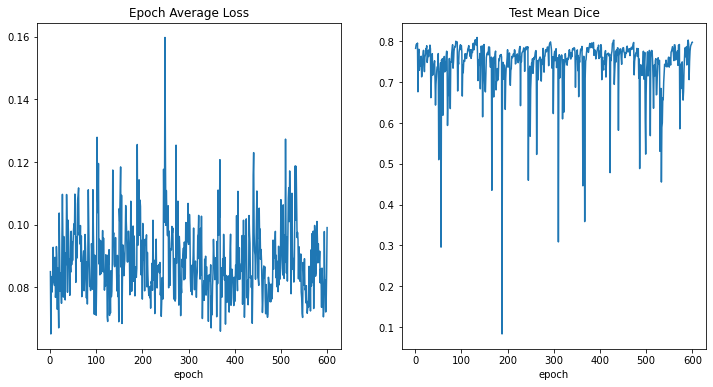

In [19]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Test Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.savefig('seg1.eps',bbox_inches='tight')
#plt.show()

tensor(3.)
tensor(0.)
tensor(3)
tensor(0)


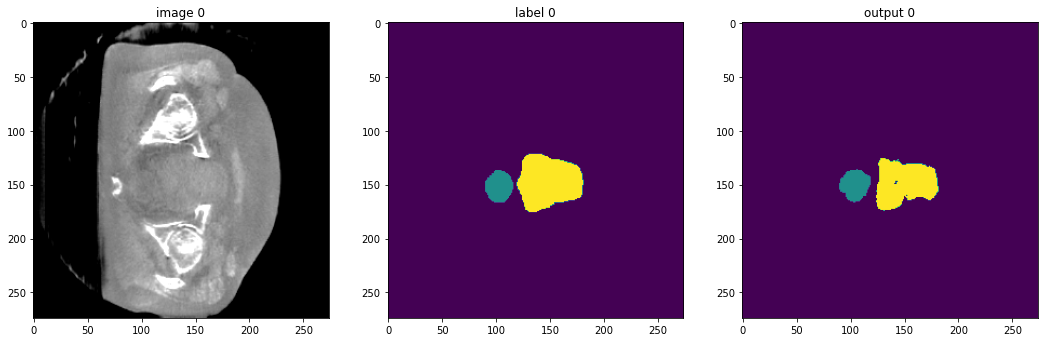

tensor(3.)
tensor(0.)
tensor(3)
tensor(0)


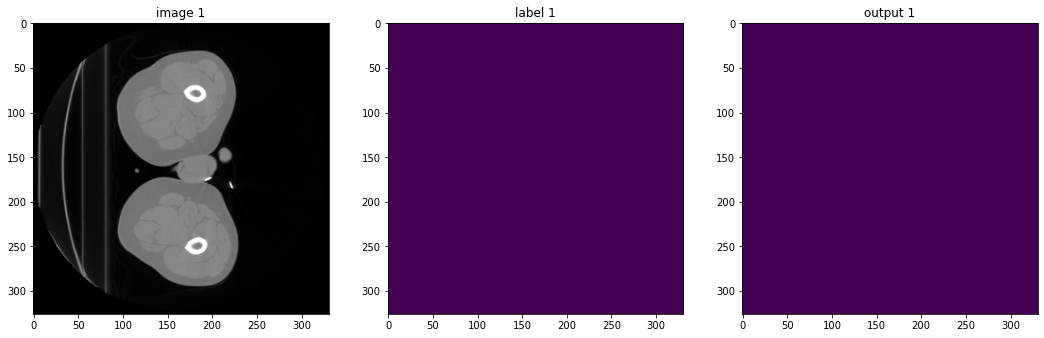

tensor(3.)
tensor(0.)
tensor(3)
tensor(0)


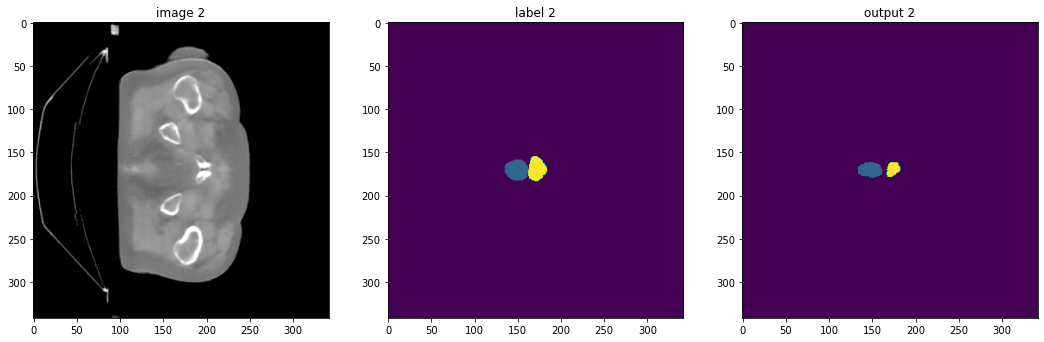

tensor(3.)
tensor(0.)
tensor(3)
tensor(0)


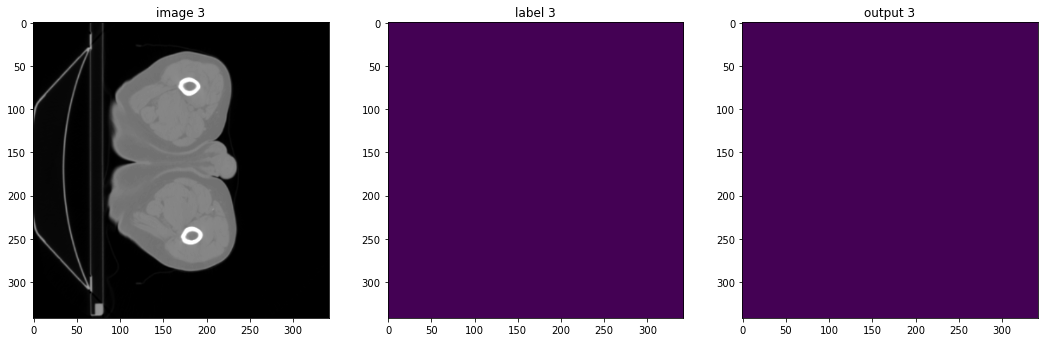

tensor(3.)
tensor(0.)
tensor(3)
tensor(0)


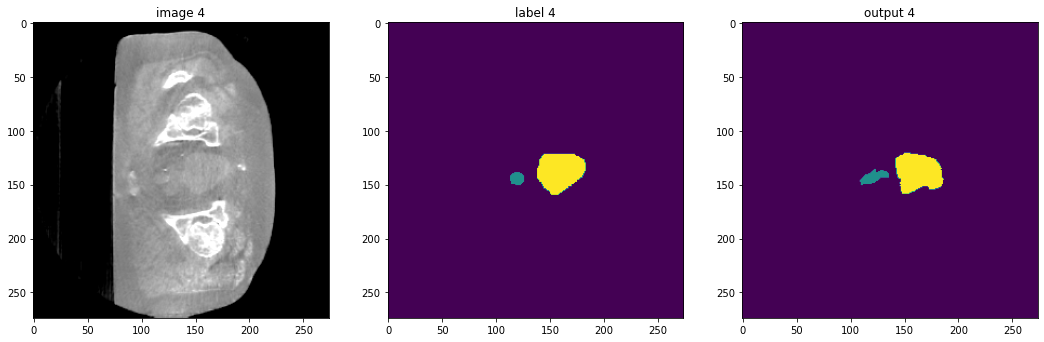

tensor(3.)
tensor(0.)
tensor(3)
tensor(0)


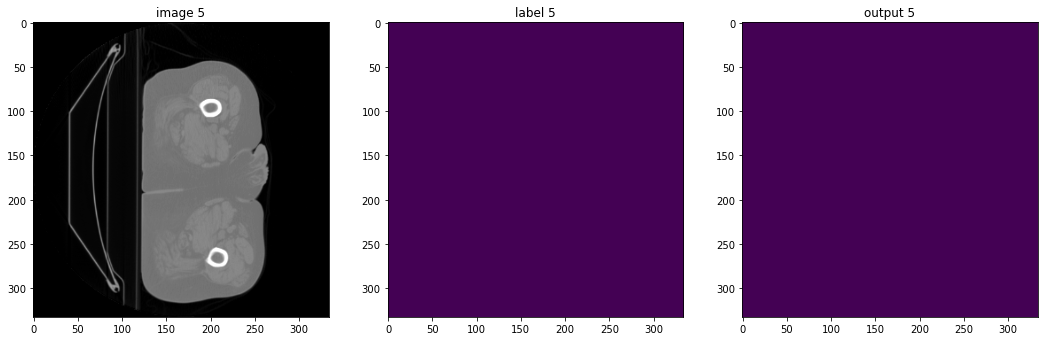

tensor(3.)
tensor(0.)
tensor(3)
tensor(0)


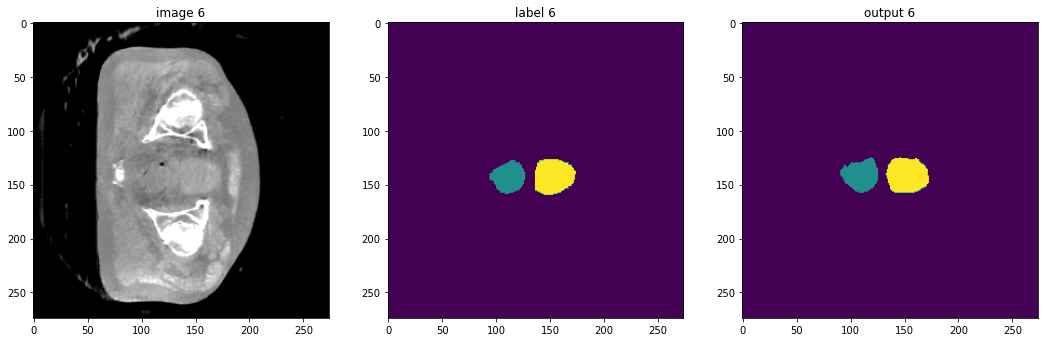

tensor(3.)
tensor(0.)
tensor(3)
tensor(0)


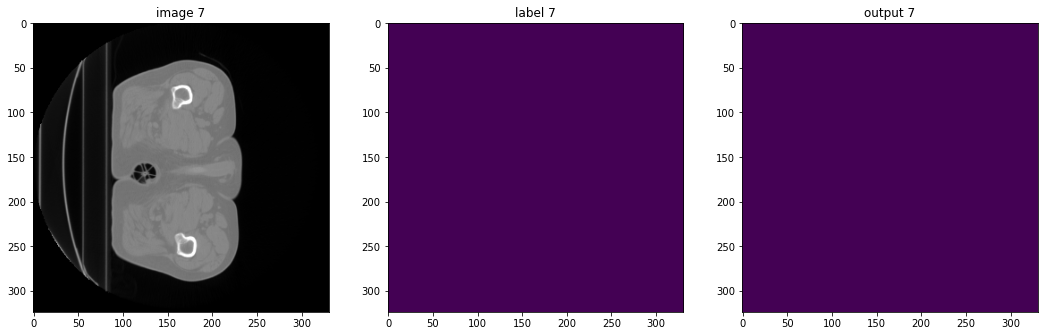

tensor(3.)
tensor(0.)
tensor(3)
tensor(0)


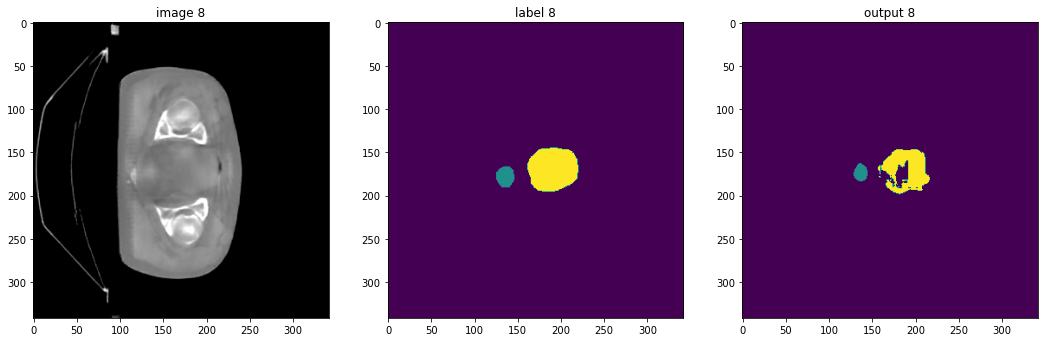

tensor(3.)
tensor(0.)
tensor(3)
tensor(0)


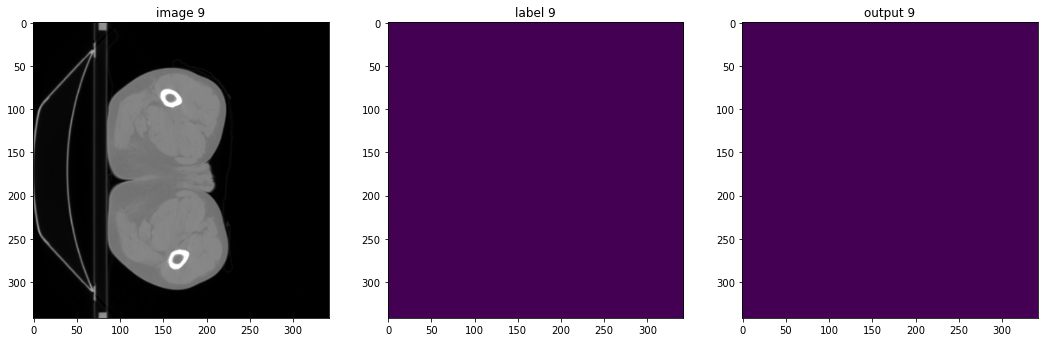

tensor(3.)
tensor(0.)
tensor(3)
tensor(0)


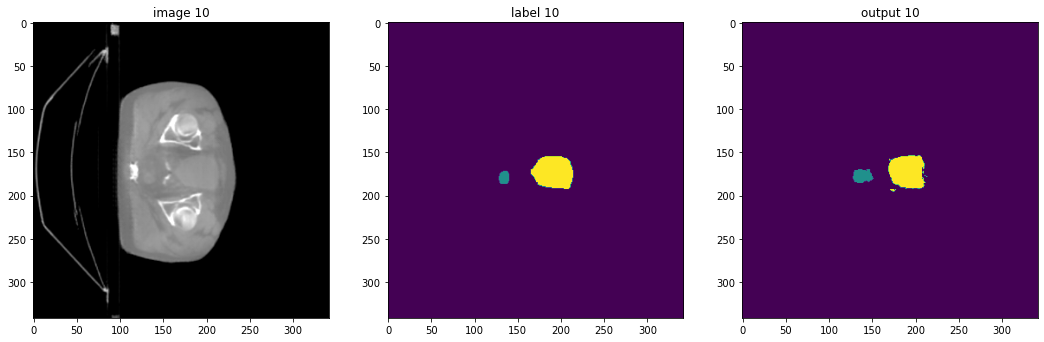

tensor(3.)
tensor(0.)
tensor(3)
tensor(0)


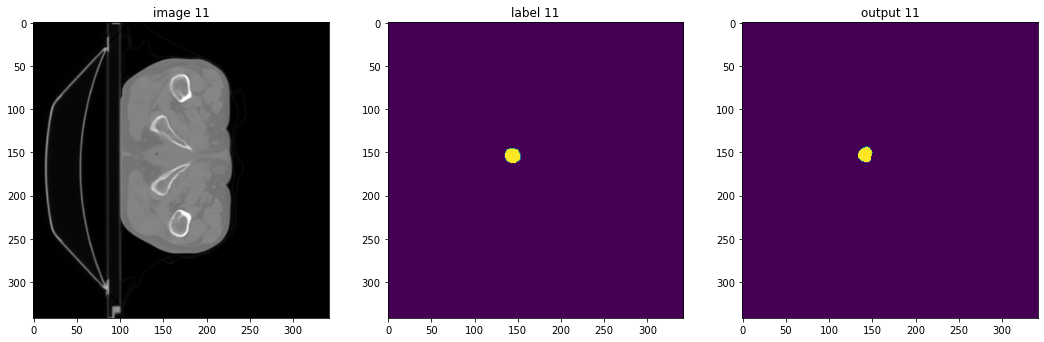

tensor(3.)
tensor(0.)
tensor(3)
tensor(0)


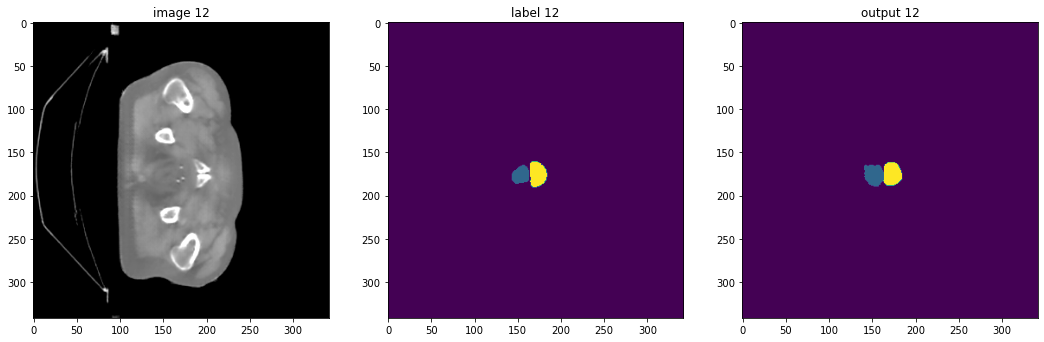

tensor(3.)
tensor(0.)
tensor(3)
tensor(0)


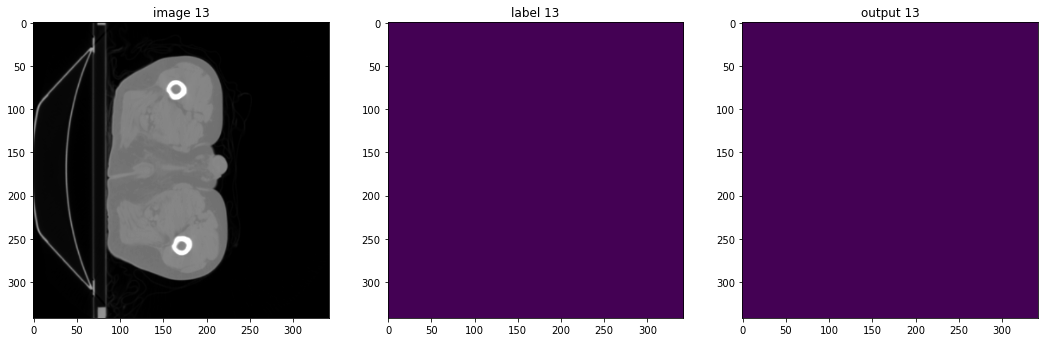

In [86]:
model.load_state_dict(torch.load(
    os.path.join(data_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (64, 64, 64)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 53], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 53])
        print(val_data["label"][0, 0, :, :, :].max())
        print(val_data["label"][0, 0, :, :, :].min())
        print(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, :].max())
        print(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, :].min())
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 53])
        plt.show()

In [94]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-1000, a_max=1000,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

val_org_ds = Dataset(
    data=train_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=val_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True),
    AsDiscreted(keys="label")
])

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(data_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        val_lab = val_data["label"].to(device)
        print(torch.min(val_lab))
        print(torch.max(val_lab))
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(
            val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        #print(torch.min(val_outputs[0]))
        #print(torch.min(val_labels[0]))
        #print(torch.max(val_outputs[0]))
        #print(torch.max(val_labels[0]))
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing on Training set: ", metric_org)

In [90]:
test_images = sorted(
    glob.glob(os.path.join(data_dir, "CBCT-Test", "*_volume.nii.gz")))
    
test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-500, a_max=500,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys="image"),
    ]
)

test_org_ds = Dataset(
    data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=test_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out-cbct", output_postfix="seg", resample=False),
])

In [91]:
from monai.transforms import LoadImage
loader = LoadImage()

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(data_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (64,64,64)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]
         # uncomment the following lines to visualize the predicted results
        test_output = from_engine(["pred"])(test_data)

        original_image = loader(test_data[0]["image_meta_dict"]["filename_or_obj"])[0]

        plt.figure("check", (18, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image[:, :, 40], cmap="gray")
        plt.subplot(1, 2, 2)
        #print(test_output[0].detach().cpu()[0, :, :, :].max())
        #print(test_output[0].detach().cpu()[0, :, :, :].min())
        plt.imshow(test_output[0].detach().cpu()[0, :, :, 40])
        plt.show()